# Machine Learning for Tracking Crypto Index

* By: Jean Philippe N'DRI
* Executive Master El Karoui (Sorbonne x Ecole Polytechnique)
* Course: Fintech

This project aims to create crypto index and replicate this index using Machine Learning Algorithm

#### Import Library

In [2]:
import pandas as pd
import yfinance as yf
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from plotly.subplots import make_subplots
import plotly.express as px

#Import Model Packages
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import AgglomerativeClustering,AffinityPropagation
from scipy.cluster.hierarchy import fcluster
from scipy.cluster.hierarchy import dendrogram, linkage, cophenet
from scipy.spatial.distance import pdist
from sklearn.metrics import adjusted_mutual_info_score
from sklearn import cluster, covariance, manifold

import re
import warnings
warnings.filterwarnings('ignore')

#### Functions

In [5]:
#Select the col to delete 
def list_col_supp(data,t):
    list_percent = (data.isnull().mean()*100)
    index_supp = [i for i, ele in enumerate(list_percent) if ele > t]
    return(data.iloc[:,index_supp].columns.to_list())

#Select the row to delete 
def list_row_supp(data):
    list_percent = data.isnull().sum(axis=1)/data.shape[0]
    index_supp = [i for i, ele in enumerate(list_percent) if ele > 50]
    return(index_supp)

#Select the categorical columns
def To_cat(ds):
    ds_cat = ds.select_dtypes(include = 'object').copy()
    return ds_cat

#Select the Numerical columns
def To_num(ds):
    ds_num = ds.select_dtypes(exclude = 'object').copy()
    return ds_num

#To download the data
def download_adj_close(ticker, start_date, end_date):
    data = yf.download(ticker, start=start_date, end=end_date)
    return data['Adj Close']


### Index creation Process

* We select the top10 crypto without Bitcoin and Etherunm
* Period: '2020-10-01' to '2024-03-29'

In [6]:
top_10_crypto = ['BNB-USD','SOL-USD','XRP-USD','ADA-USD',
                 'DOGE-USD','AVAX-USD','SHIB-USD','DOT-USD','LINK-USD','MATIC-USD']

In [7]:
# Exemple d'utilisation
prices = download_adj_close(top_10_crypto, '2020-10-01', '2024-03-29')
prices

[*********************100%%**********************]  10 of 10 completed


Ticker       ADA-USD   AVAX-USD     BNB-USD  DOGE-USD   DOT-USD   LINK-USD  \
Date                                                                         
2020-10-01  0.097865   4.151090   27.431973  0.002616  4.343831   9.649905   
2020-10-02  0.092921   3.927156   27.285681  0.002583  4.123179   9.224705   
2020-10-03  0.093413   4.021660   28.202311  0.002599  4.070046   9.304493   
2020-10-04  0.096348   3.961110   28.943853  0.002635  4.173911   9.404910   
2020-10-05  0.097544   3.978020   28.659103  0.002612  4.172700   9.623703   
...              ...        ...         ...       ...       ...        ...   
2024-03-24  0.646157  55.664196  567.994812  0.176453  9.369309  18.532669   
2024-03-25  0.656949  57.823334  587.427612  0.175367  9.737619  19.359713   
2024-03-26  0.665034  55.818089  580.150513  0.182486  9.690575  20.010675   
2024-03-27  0.648483  54.114628  574.511597  0.190330  9.443778  19.302181   
2024-03-28  0.650794  54.621883  583.270874  0.220056  9.516781  19.160713   

Ticker      MATIC-USD  SHIB-USD     SOL-USD   XRP-USD  
Date                                                   
2020-10-01   0.018980  0.000000    2.861028  0.238249  
2020-10-02   0.018272  0.000000    2.626083  0.234117  
2020-10-03   0.018550  0.000000    2.547303  0.232938  
2020-10-04   0.018602  0.000000    2.515995  0.247685  
2020-10-05   0.018841  0.000000    2.657644  0.250816  
...               ...       ...         ...       ...  
2024-03-24   1.011103  0.000028  183.573456  0.632950  
2024-03-25   1.045418  0.000029  189.083542  0.641034  
2024-03-26   1.045871  0.000031  190.699860  0.632253  
2024-03-27   1.008847  0.000030  186.361465  0.611964  
2024-03-28   1.002054  0.000032  189.621628  0.624554  

[1275 rows x 10 columns]

In [9]:
# Which col containt NaN??
for i in [5,10,20,30,40,50]:
    print(list_col_supp(prices,i))

[]
[]
[]
[]
[]
[]


In [10]:
# Retrieve the first row (the starting point)
first_row = prices.iloc[0]

# Calculate the cumulative returns
# We divide each day's prices by the first day's prices
cumulative_returns = prices / first_row

In [11]:
cumulative_returns.head()

Ticker       ADA-USD  AVAX-USD   BNB-USD  DOGE-USD   DOT-USD  LINK-USD  \
Date                                                                     
2020-10-01  1.000000  1.000000  1.000000  1.000000  1.000000  1.000000   
2020-10-02  0.949481  0.946054  0.994667  0.987385  0.949203  0.955937   
2020-10-03  0.954509  0.968820  1.028082  0.993502  0.936972  0.964206   
2020-10-04  0.984499  0.954234  1.055114  1.007263  0.960882  0.974612   
2020-10-05  0.996720  0.958307  1.044734  0.998471  0.960604  0.997285   

Ticker      MATIC-USD  SHIB-USD   SOL-USD   XRP-USD  
Date                                                 
2020-10-01   1.000000       NaN  1.000000  1.000000  
2020-10-02   0.962698       NaN  0.917881  0.982657  
2020-10-03   0.977345       NaN  0.890345  0.977708  
2020-10-04   0.980084       NaN  0.879402  1.039606  
2020-10-05   0.992677       NaN  0.928912  1.052747

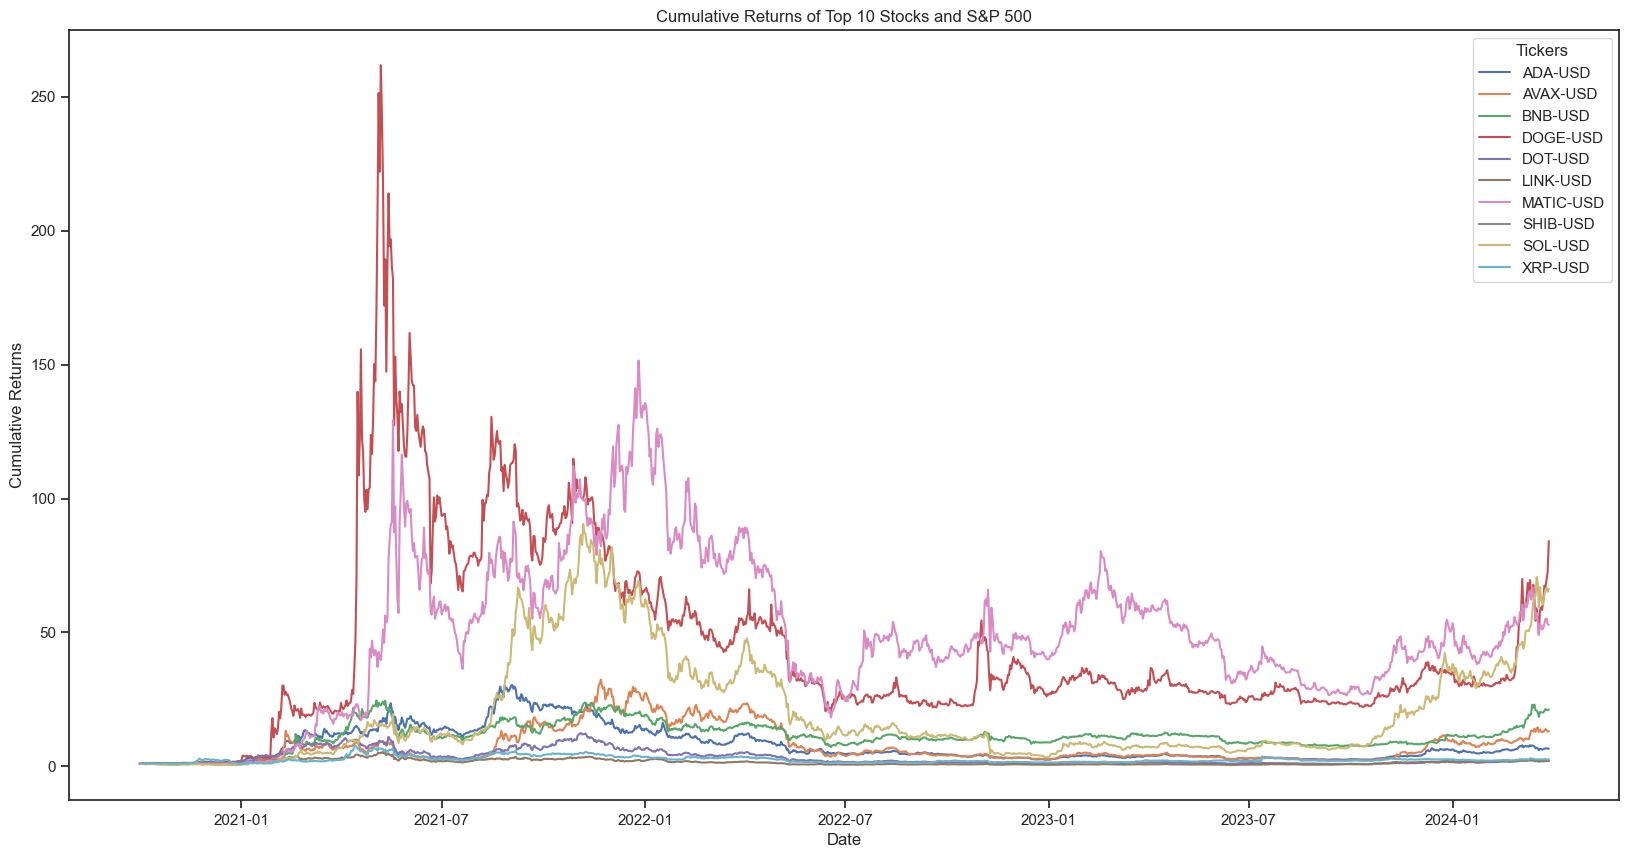

In [12]:
# Plotting the evolution of cumulative return 
# Setting the seaborn style
sns.set(style="ticks")
# Plotting the evolution using seaborn's lineplot
plt.figure(figsize=(20, 10))
for column in cumulative_returns.columns:
    sns.lineplot(data=cumulative_returns[column], label=column)

plt.title("Cumulative Returns of Top 10 Stocks and S&P 500")
plt.xlabel("Date")
plt.ylabel("Cumulative Returns")
plt.legend(title="Tickers")
plt.show()


In [14]:
# We compute the index as the sum of all crypto divide by 10
prices['Index Price']=prices.sum(axis=1)/10

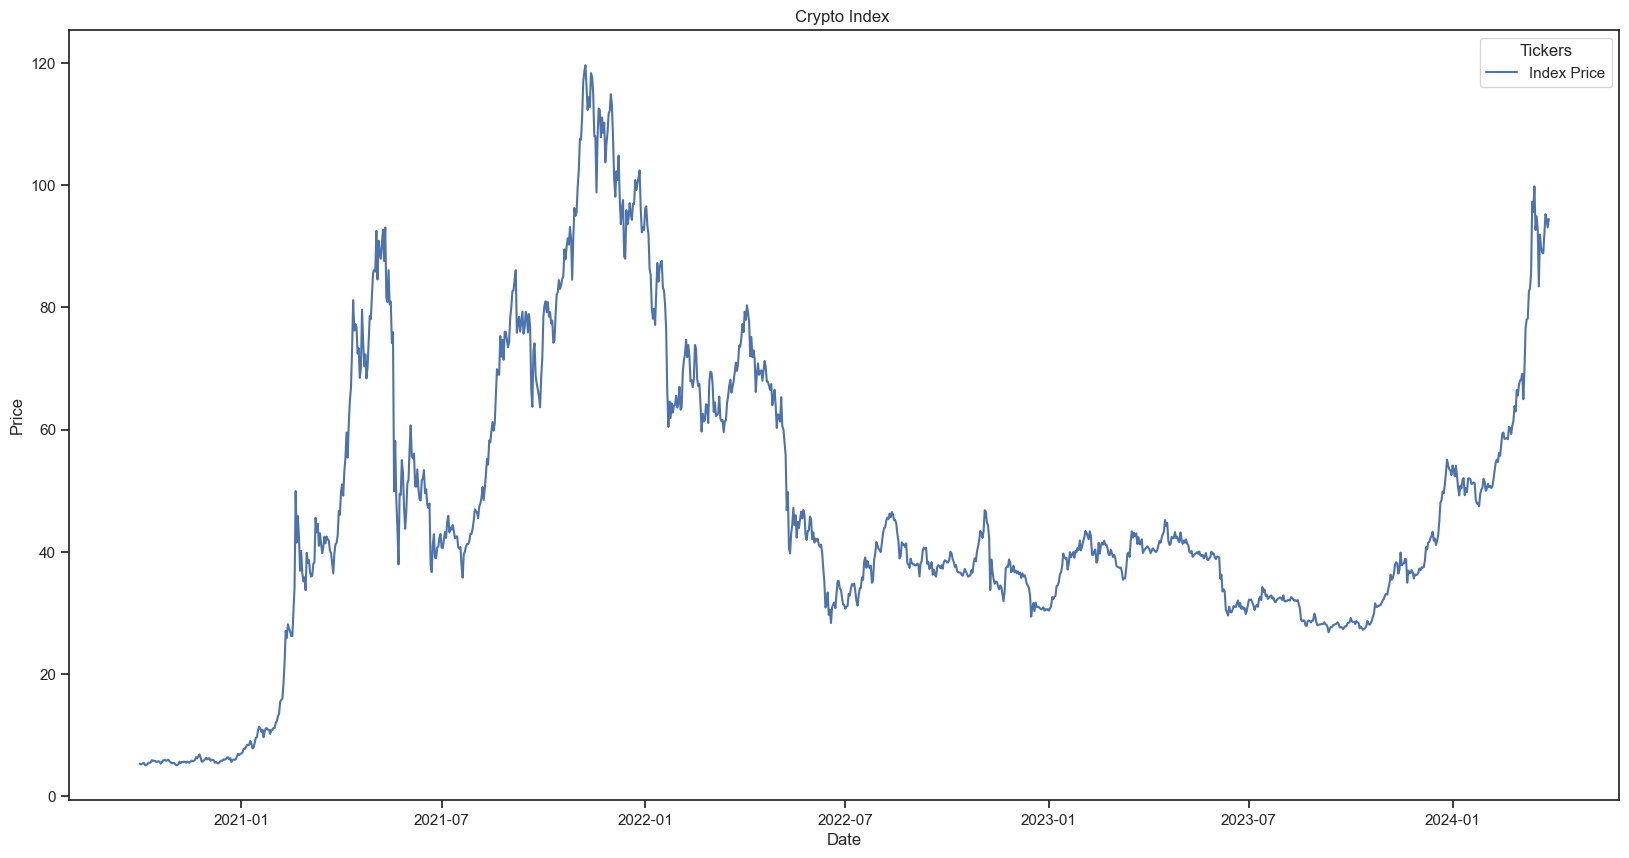

In [15]:
plt.figure(figsize=(20, 10))
sns.lineplot(data=prices['Index Price'], label='Index Price')
plt.title("Crypto Index ")
plt.xlabel("Date")
plt.ylabel("Price")
plt.legend(title="Tickers")
plt.show()

In [17]:
prices['Index Price']

Date
2020-10-01     5.367509
2020-10-02     5.228817
2020-10-03     5.334264
2020-10-04     5.430155
2020-10-05     5.440708
                ...    
2024-03-24    92.136125
2024-03-25    95.254568
2024-03-26    94.478492
2024-03-27    93.081263
2024-03-28    94.455831
Freq: D, Name: Index Price, Length: 1275, dtype: float64

In [18]:
# we take the most popular crypto as candidate to our index replication 

crypto=['BNB-USD','SOL-USD','ADA-USD','LTC-USD','LINK-USD','BCH-USD','ALGO-USD','XLM-USD',
        'FTT-USD','TRX-USD','VET-USD','FIL-USD','THETA-USD','CRO-USD','XMR-USD','EOS-USD','XTZ-USD','KSM-USD',
        'QNT-USD','BSV-USD','WAVES-USD','MKR-USD','ZEC-USD','CHZ-USD','MANA-USD','ENJ-USD','SNX-USD','UMA-USD',
        'BAT-USD', 'ATOM-USD','MATIC-USD','KDA-USD','ZIL-USD','QTUM-USD','ONT-USD','FTM-USD','ONE-USD',
        'ANKR-USD','OMG-USD','DGB-USD','SC-USD','XVG-USD','LSK-USD','BTT-USD','ICX-USD','ZRX-USD','BCD-USD',
        'VTHO-USD','IOST-USD','WIN-USD','TRX-USD','CEL-USD','AR-USD','SXP-USD','REP-USD','LRC-USD','REN-USD',
        'BAND-USD','RUNE-USD','NMR-USD','SNT-USD','DENT-USD','WAXP-USD','SHIB-USD','BNB-USD','SOL-USD','XRP-USD','ADA-USD',
                 'DOGE-USD','AVAX-USD','SHIB-USD','DOT-USD','LINK-USD']

In [19]:
# Exemple d'utilisation
df = download_adj_close(crypto, '2020-10-01', '2024-03-29')
df

[*********************100%%**********************]  67 of 67 completed


Ticker       ADA-USD  ALGO-USD  ANKR-USD     AR-USD   ATOM-USD   AVAX-USD  \
Date                                                                        
2020-10-01  0.097865  0.334291  0.007569   4.246261   5.129178   4.151090   
2020-10-02  0.092921  0.317115  0.007291   4.425807   4.908415   3.927156   
2020-10-03  0.093413  0.313876  0.007327   4.197838   5.018135   4.021660   
2020-10-04  0.096348  0.313273  0.007289   4.147193   5.306819   3.961110   
2020-10-05  0.097544  0.317872  0.007057   4.065870   5.382198   3.978020   
...              ...       ...       ...        ...        ...        ...   
2024-03-24  0.646157  0.256103  0.044482  37.523773  11.611394  55.664196   
2024-03-25  0.656949  0.268201  0.050550  42.517330  12.185326  57.823334   
2024-03-26  0.665034  0.280121  0.056710  41.186485  12.216667  55.818089   
2024-03-27  0.648483  0.270657  0.056797  42.698448  12.639974  54.114628   
2024-03-28  0.650794  0.272634  0.055381  41.494015  12.298833  54.621883   

Ticker      BAND-USD   BAT-USD   BCD-USD     BCH-USD  ...  WAXP-USD   WIN-USD  \
Date                                                  ...                       
2020-10-01  6.413685  0.230202  0.531012  227.419205  ...  0.037975  0.000083   
2020-10-02  6.074012  0.223896  0.513087  220.021805  ...  0.037075  0.000080   
2020-10-03  5.938618  0.221100  0.557907  218.863785  ...  0.037852  0.000083   
2020-10-04  5.966622  0.221511  0.536718  221.392395  ...  0.037423  0.000083   
2020-10-05  5.891822  0.221232  0.536470  222.050323  ...  0.038801  0.000083   
...              ...       ...       ...         ...  ...       ...       ...   
2024-03-24  2.098577  0.309904  0.139252  484.753632  ...  0.089436  0.000166   
2024-03-25  2.188411  0.332190  0.137378  488.045959  ...  0.099081  0.000167   
2024-03-26  2.258034  0.346510  0.148276  480.107361  ...  0.106439  0.000168   
2024-03-27  2.213657  0.337055  0.138659  539.793335  ...  0.099292  0.000160   
2024-03-28  2.225347  0.336400  0.143344  569.156982  ...  0.099431  0.000165   

Ticker       XLM-USD     XMR-USD   XRP-USD   XTZ-USD   XVG-USD    ZEC-USD  \
Date                                                                        
2020-10-01  0.073172  102.658134  0.238249  2.225466  0.004074  65.985596   
2020-10-02  0.071097  101.715714  0.234117  2.091950  0.003988  65.079826   
2020-10-03  0.071157  103.658508  0.232938  2.115696  0.004012  60.686058   
2020-10-04  0.072955  105.563141  0.247685  2.112973  0.004020  63.067760   
2020-10-05  0.073419  112.903252  0.250816  2.214748  0.004258  67.464317   
...              ...         ...       ...       ...       ...        ...   
2024-03-24  0.135005  141.886597  0.632950  1.294693  0.006006  29.774647   
2024-03-25  0.136683  142.586914  0.641034  1.350189  0.006248  30.313675   
2024-03-26  0.138183  135.327347  0.632253  1.378362  0.006554  31.625679   
2024-03-27  0.133770  137.917847  0.611964  1.390208  0.006333  30.989096   
2024-03-28  0.138054  135.064209  0.624554  1.413130  0.006328  30.781263   

Ticker       ZIL-USD   ZRX-USD  
Date                            
2020-10-01  0.019409  0.398848  
2020-10-02  0.018089  0.389794  
2020-10-03  0.018595  0.376901  
2020-10-04  0.021277  0.376209  
2020-10-05  0.020796  0.377584  
...              ...       ...  
2024-03-24  0.033921  0.920500  
2024-03-25  0.035947  1.004046  
2024-03-26  0.037294  1.044468  
2024-03-27  0.035477  1.068885  
2024-03-28  0.037310  1.047173  

[1275 rows x 67 columns]

In [21]:
# Which col containt NaN??
for i in [5,10,20,30,40,50]:
    print(list_col_supp(df,i))

[]
[]
[]
[]
[]
[]


<Axes: title={'center': 'Correlation Matrix'}, xlabel='Ticker', ylabel='Ticker'>

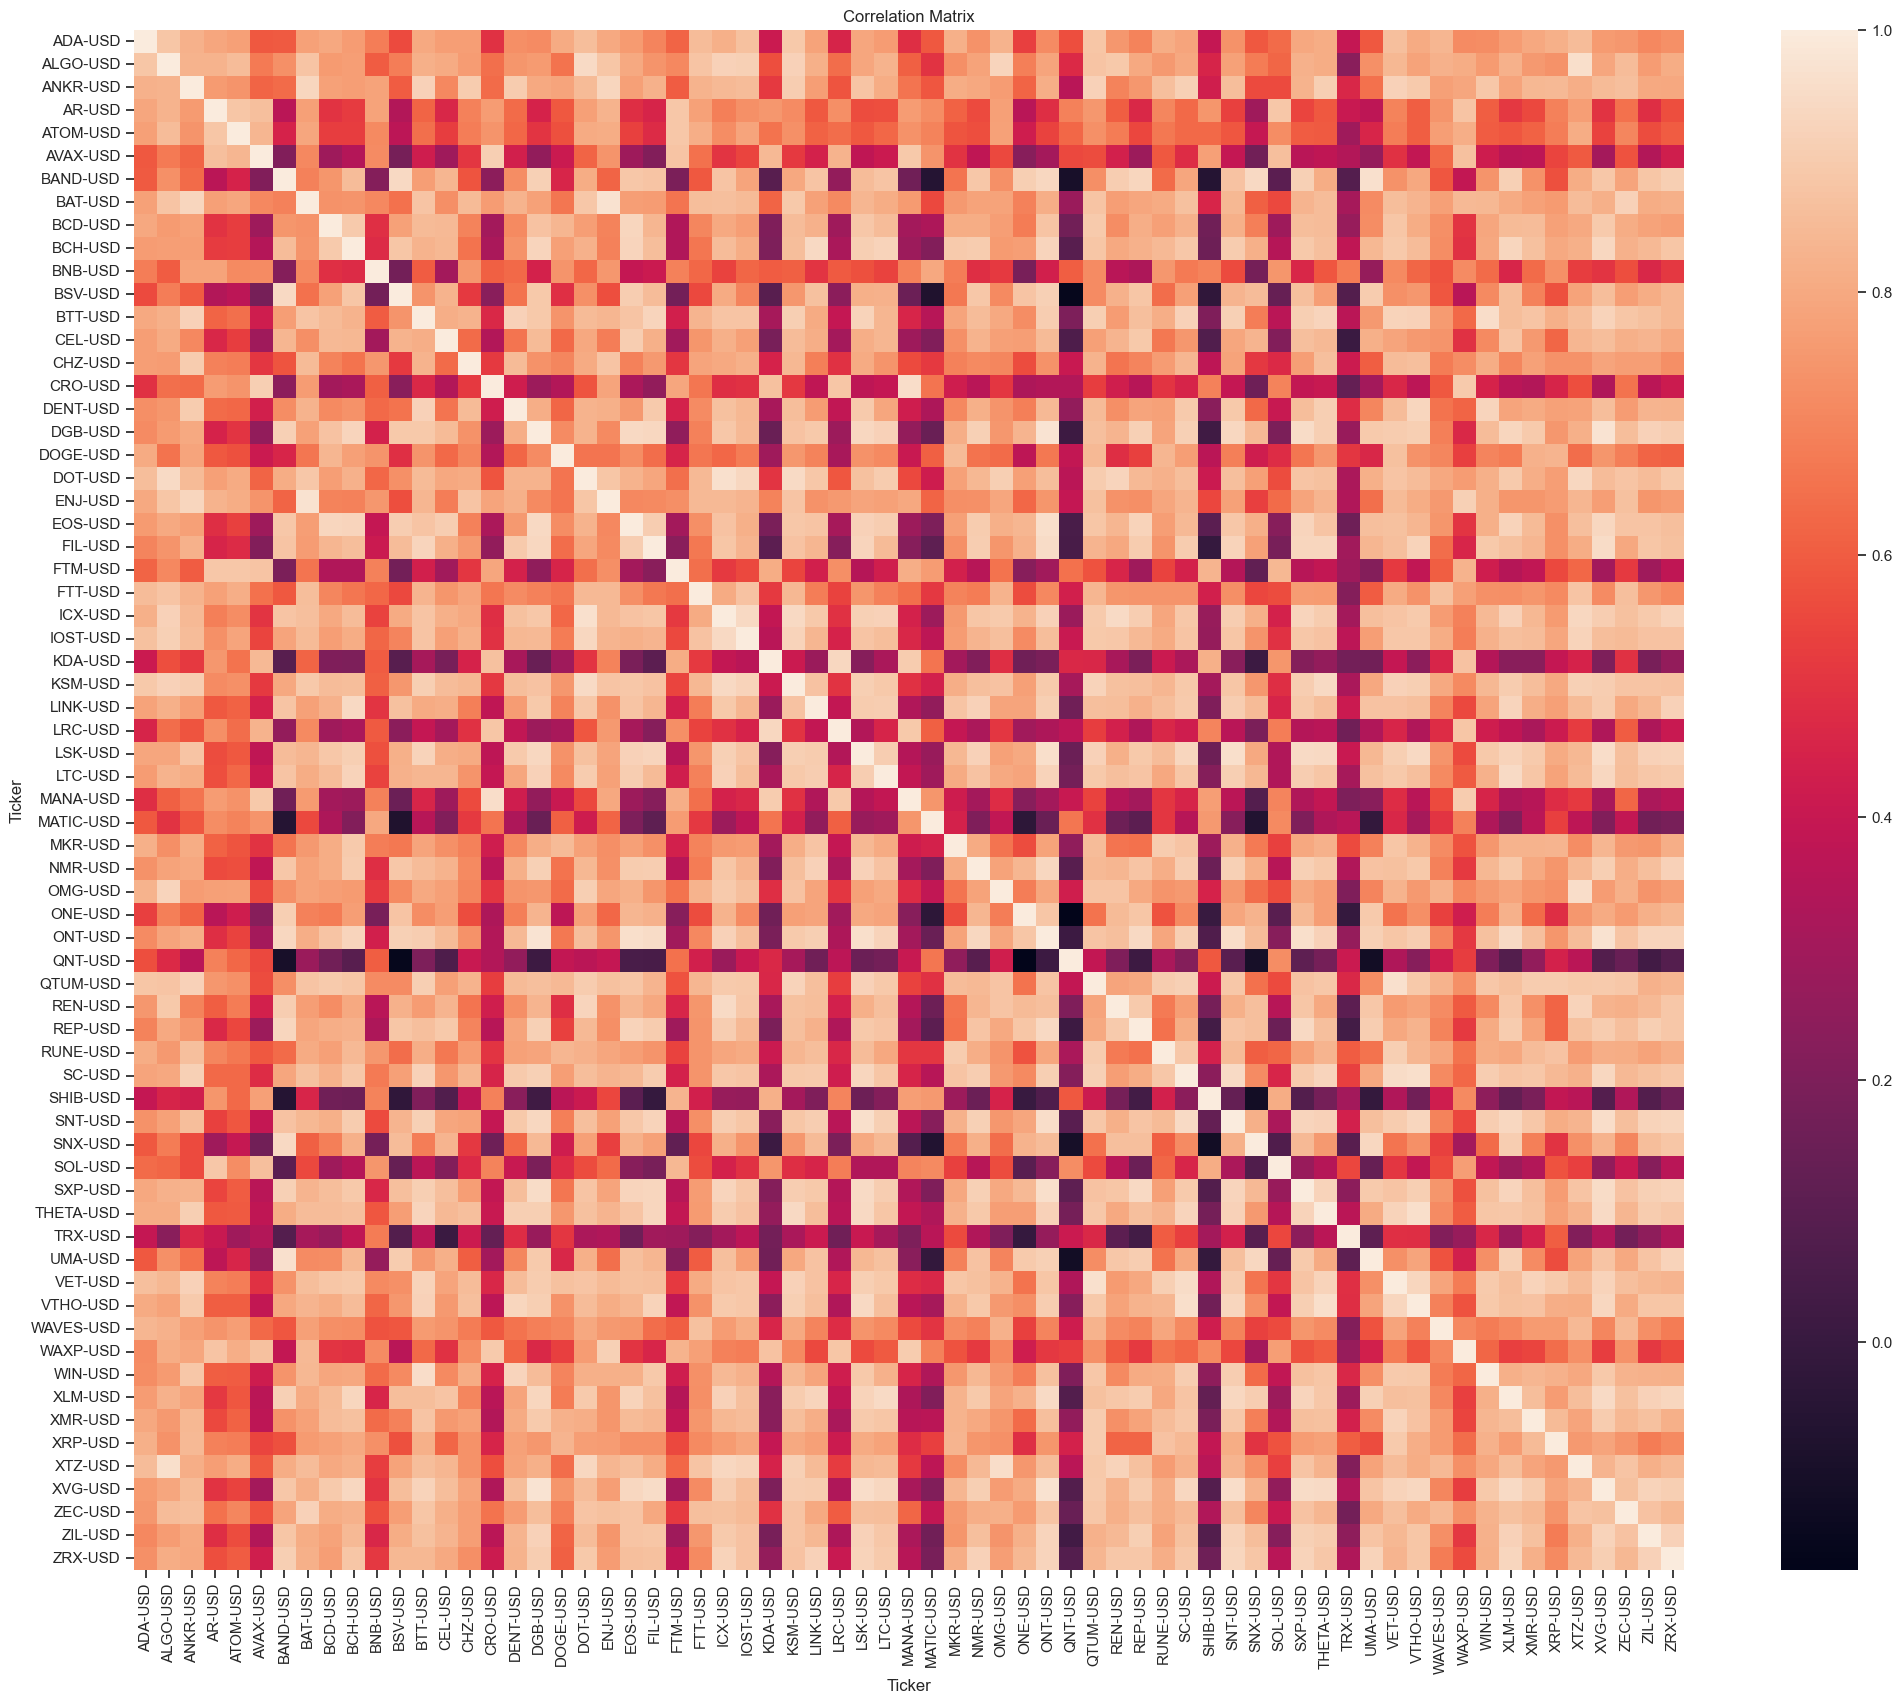

In [25]:
# correlation
correlation = df.corr()
plt.figure(figsize=(25,20))
plt.title('Correlation Matrix')
sns.heatmap(correlation, vmax=1, square=False,annot=False)

In [26]:
df

Ticker       ADA-USD  ALGO-USD  ANKR-USD     AR-USD   ATOM-USD   AVAX-USD  \
Date                                                                        
2020-10-01  0.097865  0.334291  0.007569   4.246261   5.129178   4.151090   
2020-10-02  0.092921  0.317115  0.007291   4.425807   4.908415   3.927156   
2020-10-03  0.093413  0.313876  0.007327   4.197838   5.018135   4.021660   
2020-10-04  0.096348  0.313273  0.007289   4.147193   5.306819   3.961110   
2020-10-05  0.097544  0.317872  0.007057   4.065870   5.382198   3.978020   
...              ...       ...       ...        ...        ...        ...   
2024-03-24  0.646157  0.256103  0.044482  37.523773  11.611394  55.664196   
2024-03-25  0.656949  0.268201  0.050550  42.517330  12.185326  57.823334   
2024-03-26  0.665034  0.280121  0.056710  41.186485  12.216667  55.818089   
2024-03-27  0.648483  0.270657  0.056797  42.698448  12.639974  54.114628   
2024-03-28  0.650794  0.272634  0.055381  41.494015  12.298833  54.621883   

Ticker      BAND-USD   BAT-USD   BCD-USD     BCH-USD  ...  WAXP-USD   WIN-USD  \
Date                                                  ...                       
2020-10-01  6.413685  0.230202  0.531012  227.419205  ...  0.037975  0.000083   
2020-10-02  6.074012  0.223896  0.513087  220.021805  ...  0.037075  0.000080   
2020-10-03  5.938618  0.221100  0.557907  218.863785  ...  0.037852  0.000083   
2020-10-04  5.966622  0.221511  0.536718  221.392395  ...  0.037423  0.000083   
2020-10-05  5.891822  0.221232  0.536470  222.050323  ...  0.038801  0.000083   
...              ...       ...       ...         ...  ...       ...       ...   
2024-03-24  2.098577  0.309904  0.139252  484.753632  ...  0.089436  0.000166   
2024-03-25  2.188411  0.332190  0.137378  488.045959  ...  0.099081  0.000167   
2024-03-26  2.258034  0.346510  0.148276  480.107361  ...  0.106439  0.000168   
2024-03-27  2.213657  0.337055  0.138659  539.793335  ...  0.099292  0.000160   
2024-03-28  2.225347  0.336400  0.143344  569.156982  ...  0.099431  0.000165   

Ticker       XLM-USD     XMR-USD   XRP-USD   XTZ-USD   XVG-USD    ZEC-USD  \
Date                                                                        
2020-10-01  0.073172  102.658134  0.238249  2.225466  0.004074  65.985596   
2020-10-02  0.071097  101.715714  0.234117  2.091950  0.003988  65.079826   
2020-10-03  0.071157  103.658508  0.232938  2.115696  0.004012  60.686058   
2020-10-04  0.072955  105.563141  0.247685  2.112973  0.004020  63.067760   
2020-10-05  0.073419  112.903252  0.250816  2.214748  0.004258  67.464317   
...              ...         ...       ...       ...       ...        ...   
2024-03-24  0.135005  141.886597  0.632950  1.294693  0.006006  29.774647   
2024-03-25  0.136683  142.586914  0.641034  1.350189  0.006248  30.313675   
2024-03-26  0.138183  135.327347  0.632253  1.378362  0.006554  31.625679   
2024-03-27  0.133770  137.917847  0.611964  1.390208  0.006333  30.989096   
2024-03-28  0.138054  135.064209  0.624554  1.413130  0.006328  30.781263   

Ticker       ZIL-USD   ZRX-USD  
Date                            
2020-10-01  0.019409  0.398848  
2020-10-02  0.018089  0.389794  
2020-10-03  0.018595  0.376901  
2020-10-04  0.021277  0.376209  
2020-10-05  0.020796  0.377584  
...              ...       ...  
2024-03-24  0.033921  0.920500  
2024-03-25  0.035947  1.004046  
2024-03-26  0.037294  1.044468  
2024-03-27  0.035477  1.068885  
2024-03-28  0.037310  1.047173  

[1275 rows x 67 columns]

In [27]:
# Merge the df with the index price
data=pd.merge(df, prices)
data.index=prices.index

In [28]:
data

Ticker       ADA-USD  ALGO-USD  ANKR-USD     AR-USD   ATOM-USD   AVAX-USD  \
Date                                                                        
2020-10-01  0.097865  0.334291  0.007569   4.246261   5.129178   4.151090   
2020-10-02  0.092921  0.317115  0.007291   4.425807   4.908415   3.927156   
2020-10-03  0.093413  0.313876  0.007327   4.197838   5.018135   4.021660   
2020-10-04  0.096348  0.313273  0.007289   4.147193   5.306819   3.961110   
2020-10-05  0.097544  0.317872  0.007057   4.065870   5.382198   3.978020   
...              ...       ...       ...        ...        ...        ...   
2024-03-24  0.646157  0.256103  0.044482  37.523773  11.611394  55.664196   
2024-03-25  0.656949  0.268201  0.050550  42.517330  12.185326  57.823334   
2024-03-26  0.665034  0.280121  0.056710  41.186485  12.216667  55.818089   
2024-03-27  0.648483  0.270657  0.056797  42.698448  12.639974  54.114628   
2024-03-28  0.650794  0.272634  0.055381  41.494015  12.298833  54.621883   

Ticker      BAND-USD   BAT-USD   BCD-USD     BCH-USD  ...   WIN-USD   XLM-USD  \
Date                                                  ...                       
2020-10-01  6.413685  0.230202  0.531012  227.419205  ...  0.000083  0.073172   
2020-10-02  6.074012  0.223896  0.513087  220.021805  ...  0.000080  0.071097   
2020-10-03  5.938618  0.221100  0.557907  218.863785  ...  0.000083  0.071157   
2020-10-04  5.966622  0.221511  0.536718  221.392395  ...  0.000083  0.072955   
2020-10-05  5.891822  0.221232  0.536470  222.050323  ...  0.000083  0.073419   
...              ...       ...       ...         ...  ...       ...       ...   
2024-03-24  2.098577  0.309904  0.139252  484.753632  ...  0.000166  0.135005   
2024-03-25  2.188411  0.332190  0.137378  488.045959  ...  0.000167  0.136683   
2024-03-26  2.258034  0.346510  0.148276  480.107361  ...  0.000168  0.138183   
2024-03-27  2.213657  0.337055  0.138659  539.793335  ...  0.000160  0.133770   
2024-03-28  2.225347  0.336400  0.143344  569.156982  ...  0.000165  0.138054   

Ticker         XMR-USD   XRP-USD   XTZ-USD   XVG-USD    ZEC-USD   ZIL-USD  \
Date                                                                        
2020-10-01  102.658134  0.238249  2.225466  0.004074  65.985596  0.019409   
2020-10-02  101.715714  0.234117  2.091950  0.003988  65.079826  0.018089   
2020-10-03  103.658508  0.232938  2.115696  0.004012  60.686058  0.018595   
2020-10-04  105.563141  0.247685  2.112973  0.004020  63.067760  0.021277   
2020-10-05  112.903252  0.250816  2.214748  0.004258  67.464317  0.020796   
...                ...       ...       ...       ...        ...       ...   
2024-03-24  141.886597  0.632950  1.294693  0.006006  29.774647  0.033921   
2024-03-25  142.586914  0.641034  1.350189  0.006248  30.313675  0.035947   
2024-03-26  135.327347  0.632253  1.378362  0.006554  31.625679  0.037294   
2024-03-27  137.917847  0.611964  1.390208  0.006333  30.989096  0.035477   
2024-03-28  135.064209  0.624554  1.413130  0.006328  30.781263  0.037310   

Ticker       ZRX-USD  Index Price  
Date                               
2020-10-01  0.398848     5.367509  
2020-10-02  0.389794     5.228817  
2020-10-03  0.376901     5.334264  
2020-10-04  0.376209     5.430155  
2020-10-05  0.377584     5.440708  
...              ...          ...  
2024-03-24  0.920500    92.136125  
2024-03-25  1.004046    95.254568  
2024-03-26  1.044468    94.478492  
2024-03-27  1.068885    93.081263  
2024-03-28  1.047173    94.455831  

[1275 rows x 68 columns]

In [29]:
len(data.columns)

68

In [31]:
# Compute the return
returns = (data - data.shift(1)) / (data.shift(1)+0.000001)

In [32]:
#Calculate average annual percentage return and volatilities over a theoretical one year period
returns = returns.mean() * 252
returns = pd.DataFrame(returns)
returns.columns = ['Returns']
returns['Volatility'] = data.pct_change().std() * np.sqrt(252)
data_cluster=returns

In [33]:
data_cluster.max()

Returns       1.949016
Volatility    1.986221
dtype: float64

In [34]:
#Scale the data
scaler = StandardScaler().fit(data_cluster)
rescaledDataset = pd.DataFrame(scaler.fit_transform(data_cluster),columns = data_cluster.columns, index = data_cluster.index)
# summarize transformed data
rescaledDataset.head(2)
X=rescaledDataset

In [35]:
X=X.dropna()

In [36]:
X

Returns  Volatility
Ticker                           
ADA-USD      0.046183   -1.098041
ALGO-USD    -0.889835   -0.707529
ANKR-USD     0.622417    0.098224
AR-USD       1.217804    0.928345
ATOM-USD    -0.168328   -0.413143
...               ...         ...
XVG-USD      0.207870    1.020899
ZEC-USD     -1.222073   -0.852104
ZIL-USD     -0.006420    0.387894
ZRX-USD      0.037114   -0.008920
Index Price  0.375774   -1.600451

[66 rows x 2 columns]

# Affinity Propagation Algorithm as sample Selection Methods

### Affinity Propagation Algorithm

Affinity Propagation (AP) is a clustering algorithm that does not require the number of clusters to be determined before running the algorithm. It operates by passing messages between data points and considering all data points as potential exemplars (cluster centers).

#### Key Concepts

1. **Exemplars**: Each cluster is represented by a data point known as an exemplar. Ideally, an exemplar is the most representative point of its cluster.

2. **Similarity**: The similarity (`s(i, k)`) between two points `i` and `k` is typically the negative square of the Euclidean distance. For a point `k`, the value of `s(k, k)`, called preference, influences the likelihood of `k` becoming an exemplar.

#### Mathematical Formulations

The algorithm proceeds by iteratively updating two types of messages:

1. **Responsibility** (`r(i, k)`): Sent from data point `i` to candidate exemplar `k`, this value reflects how well-suited `k` is to serve as the exemplar for `i`, considering other potential exemplars for `i`. It is calculated as:

   $$ r(i, k) \leftarrow s(i, k) - \max_{k' \neq k} \left\{ a(i, k') + s(i, k') \right\} $$

   where `a(i, k')` is the availability (see below) of point `k'` to be the exemplar for `i`.

2. **Availability** (`a(i, k)`): Sent from candidate exemplar `k` to data point `i`, this value indicates how appropriate it is for `i` to choose `k` as its exemplar, considering the support for `k` by other points that consider it their exemplar. It is calculated as:

   $$ a(i, k) \leftarrow \min \left( 0, r(k, k) + \sum_{i' \notin \{ i, k \}} \max(0, r(i', k)) \right) $$

   For `k` itself, the availability is updated differently:

   $$ a(k, k) \leftarrow \sum_{i' \neq k} \max(0, r(i', k)) $$

#### Algorithm Process

1. **Initialization**: Responsibilities and availabilities are initialized to zero.

2. **Message Updating**: Responsibilities and availabilities are updated according to the above formulas. These updates are done iteratively.

3. **Convergence**: The algorithm continues updating the messages until the decisions about exemplars remain unchanged for a certain number of consecutive iterations.

4. **Identifying Exemplars and Forming Clusters**: After convergence, data points for which the sum of responsibility and availability is positive (`r(i, k) + a(i, k) > 0`) are chosen as exemplars. Each data point is then assigned to the cluster of the most appropriate exemplar.

#### Important Points

- The choice of preferences (`s(k, k)`) is crucial. Higher values lead to more clusters, while lower values tend to produce fewer clusters.
- Convergence parameters need to be carefully chosen to ensure a balance between accuracy and computational time.
- AP can be more computationally intensive than other methods like K-means, especially for large datasets.

In [40]:
ap = AffinityPropagation(damping = 0.5, max_iter = 250, affinity = 'euclidean')
ap.fit(X)
clust_labels2 = ap.predict(X)

In [41]:
clust_labels2

array([2, 7, 8, 0, 5, 0, 1, 5, 1, 5, 2, 7, 4, 0, 7, 0, 7, 3, 5, 8, 7, 1,
       0, 4, 5, 5, 0, 5, 5, 4, 5, 6, 0, 0, 5, 8, 7, 7, 7, 2, 5, 1, 1, 0,
       8, 8, 8, 0, 7, 5, 6, 1, 5, 0, 8, 8, 8, 5, 6, 5, 7, 4, 7, 8, 8, 2])

In [42]:
cluster_label = pd.concat([pd.DataFrame(X.index), pd.DataFrame(clust_labels2)],axis = 1)
cluster_label.columns =['Company','Cluster']
cluster_label.sort_values(by=['Cluster'])

Company  Cluster
32  MANA-USD        0
53  VTHO-USD        0
15  DENT-USD        0
3     AR-USD        0
47   SOL-USD        0
..       ...      ...
45   SNT-USD        8
44    SC-USD        8
64   ZRX-USD        8
56   WIN-USD        8
19   ENJ-USD        8

[66 rows x 2 columns]

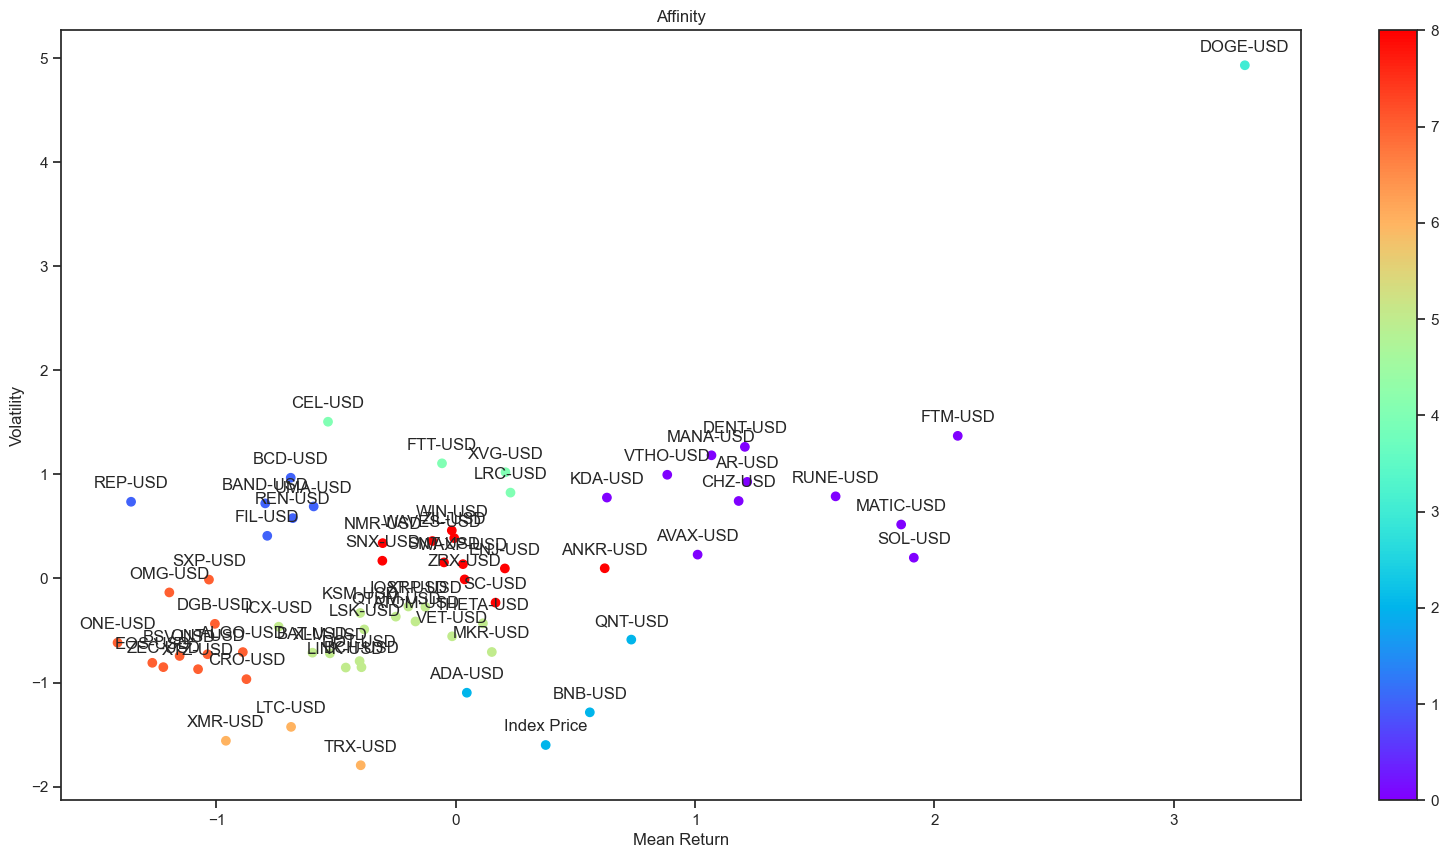

In [43]:
fig = plt.figure(figsize=(20,10))
ax = fig.add_subplot(111)
scatter = ax.scatter(X.iloc[:,0],X.iloc[:,1], c =clust_labels2, cmap ="rainbow")
ax.set_title('Affinity')
ax.set_xlabel('Mean Return')
ax.set_ylabel('Volatility')
plt.colorbar(scatter)

# zip joins x and y coordinates in pairs
for x,y,name in zip(X.iloc[:,0],X.iloc[:,1],X.index):

    label = name

    plt.annotate(label, # this is the text
                 (x,y), # this is the point to label
                 textcoords="offset points", # how to position the text
                 xytext=(0,10), # distance from text to points (x,y)
                 ha='center') # horizontal alignment can be left, right or center
    
fig.savefig("affinity_scatter_plot.png")



['AR-USD', 'AVAX-USD', 'CHZ-USD', 'DENT-USD', 'FTM-USD', 'KDA-USD', 'MANA-USD', 'MATIC-USD', 'RUNE-USD', 'SOL-USD', 'VTHO-USD']


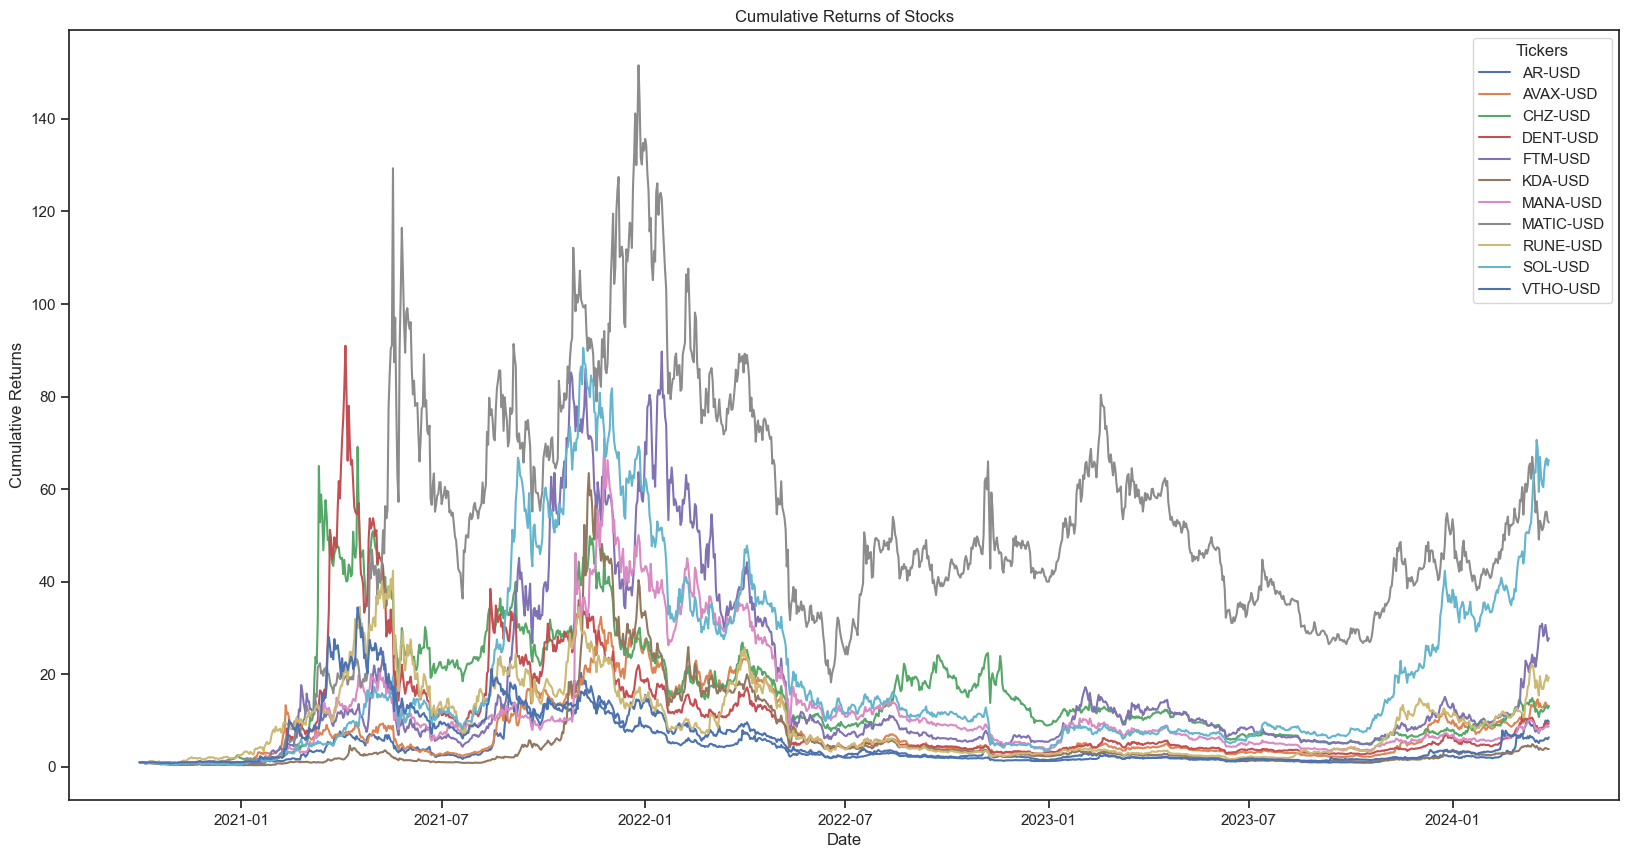

['BAND-USD', 'BCD-USD', 'FIL-USD', 'REN-USD', 'REP-USD', 'UMA-USD']


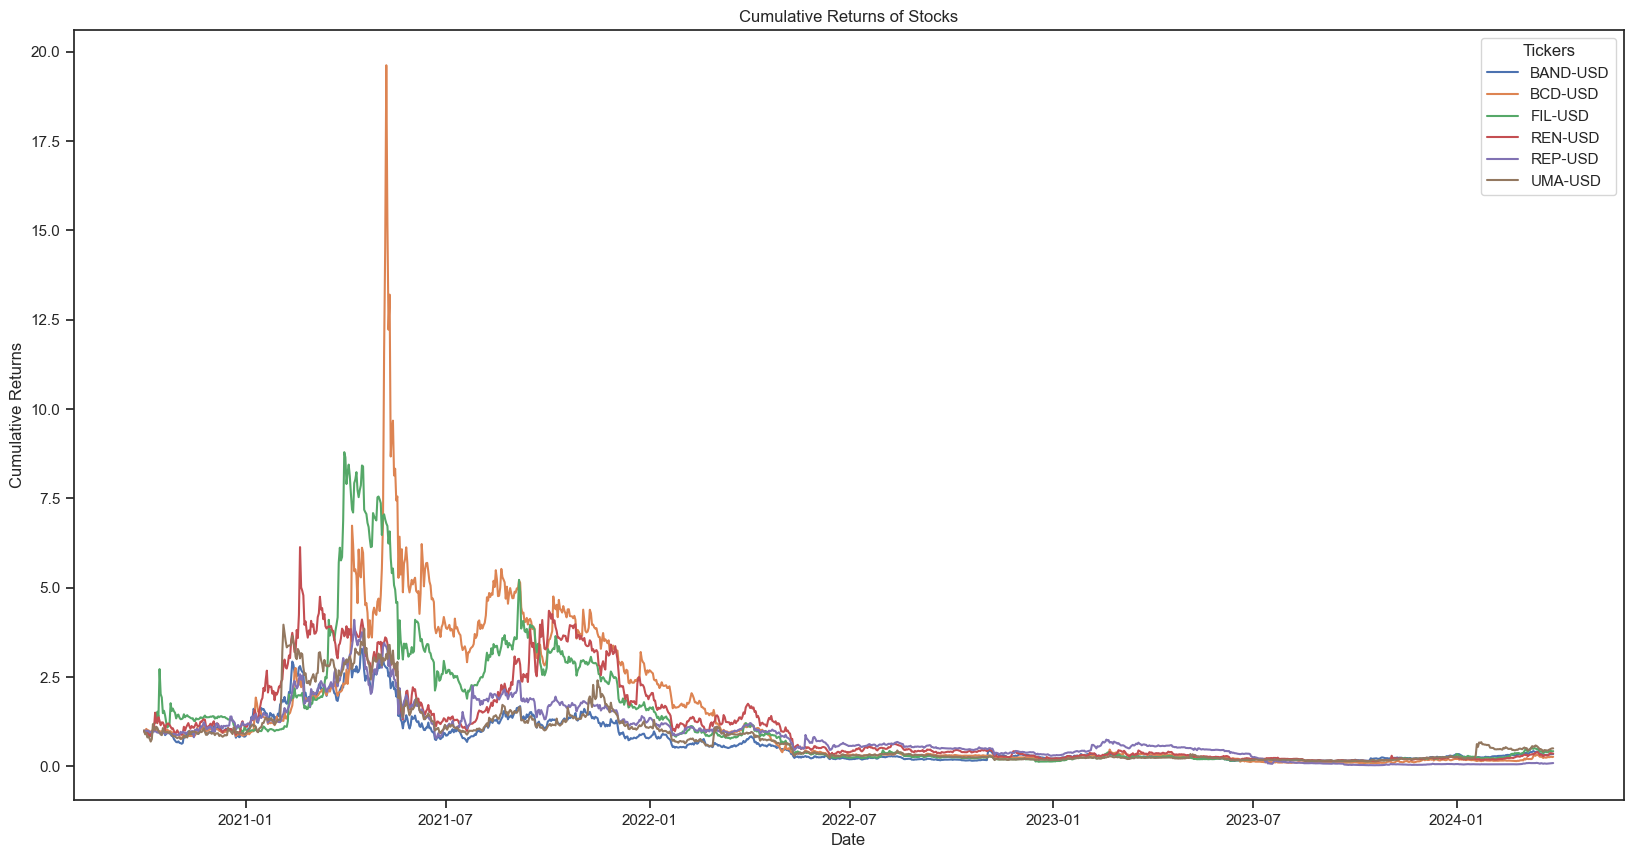

['ADA-USD', 'BNB-USD', 'QNT-USD', 'Index Price']


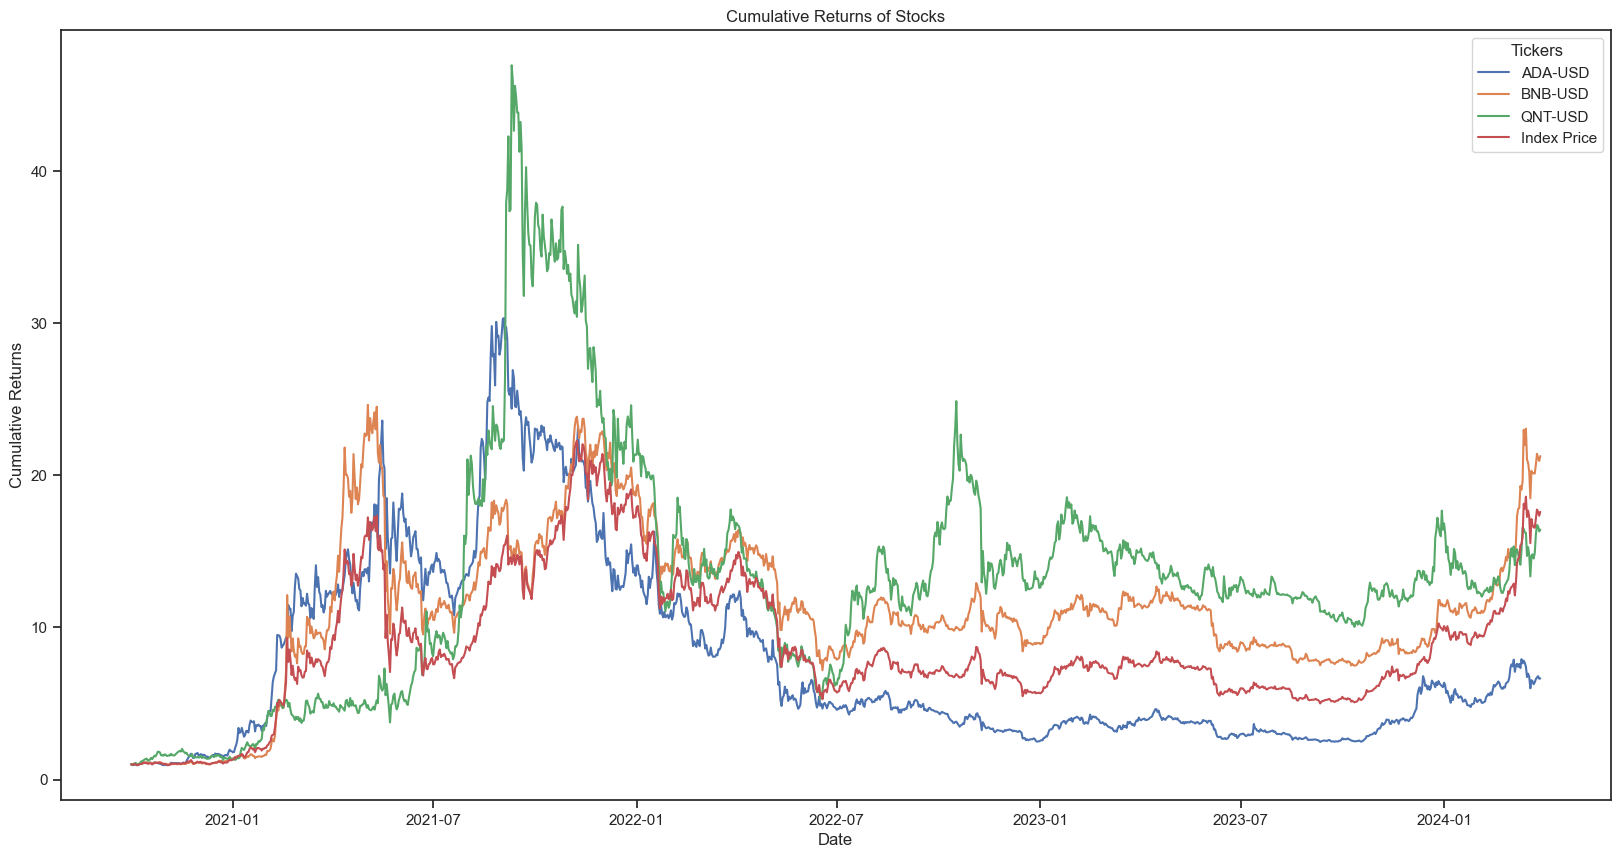

['DOGE-USD']


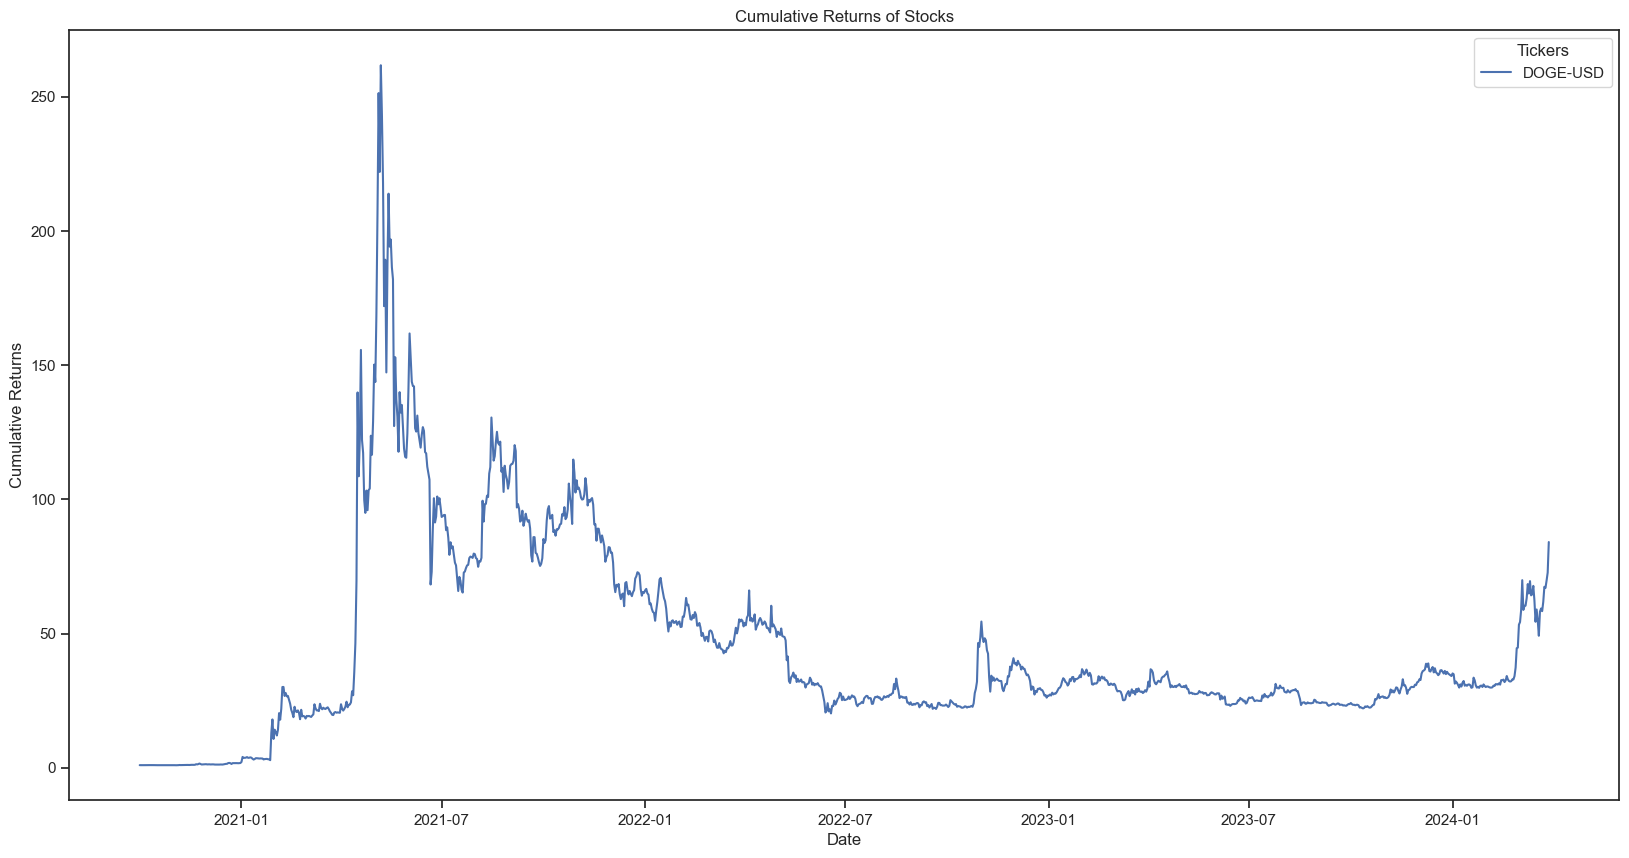

['CEL-USD', 'FTT-USD', 'LRC-USD', 'XVG-USD']


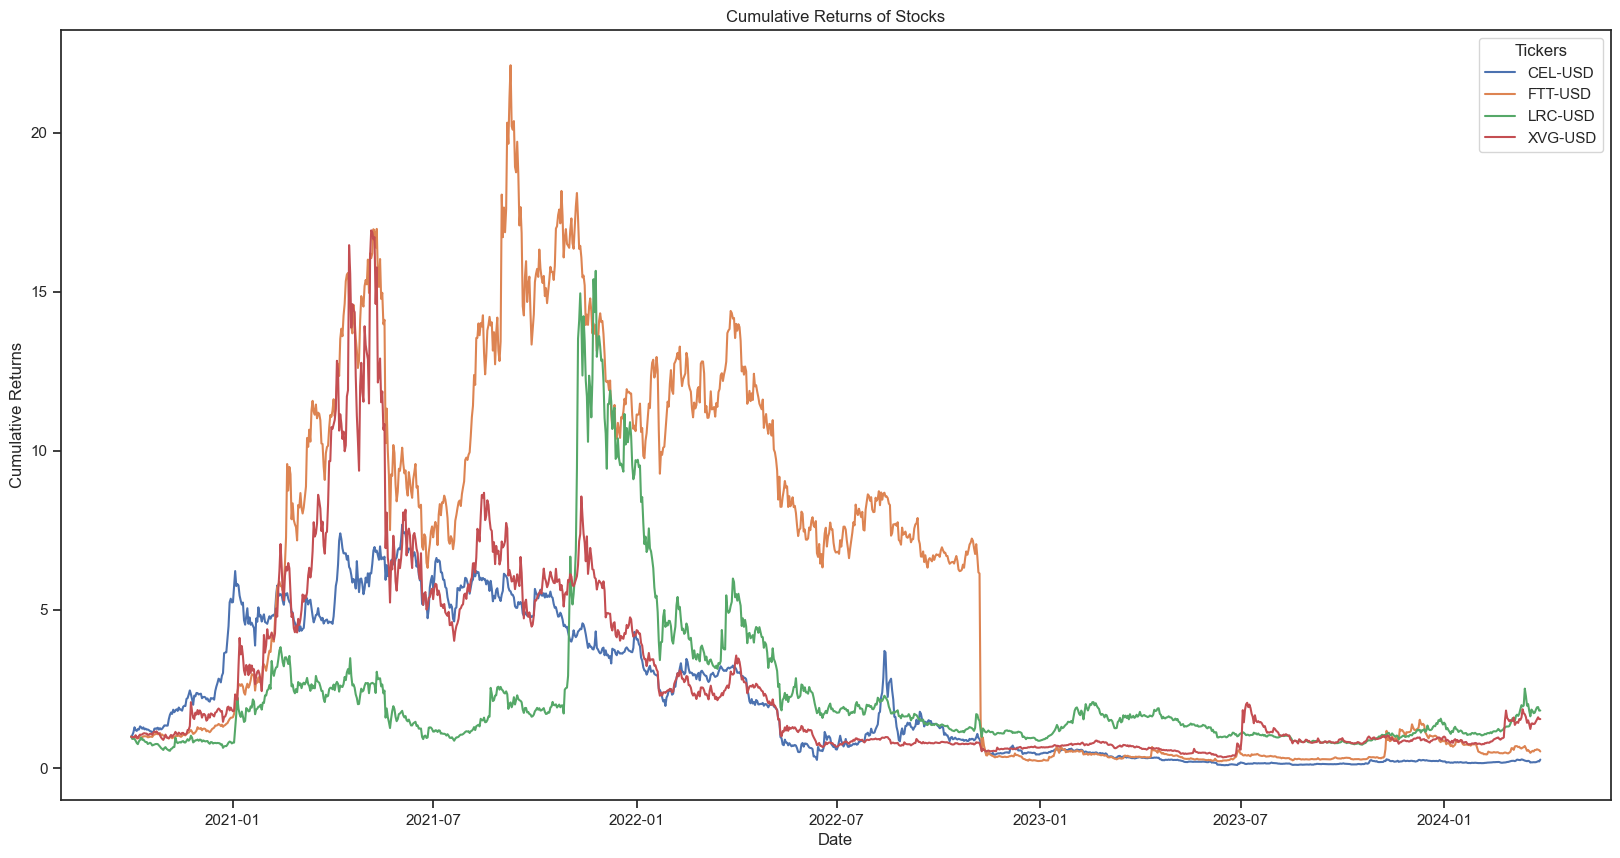

['ATOM-USD', 'BAT-USD', 'BCH-USD', 'DOT-USD', 'ICX-USD', 'IOST-USD', 'KSM-USD', 'LINK-USD', 'LSK-USD', 'MKR-USD', 'QTUM-USD', 'THETA-USD', 'VET-USD', 'XLM-USD', 'XRP-USD']


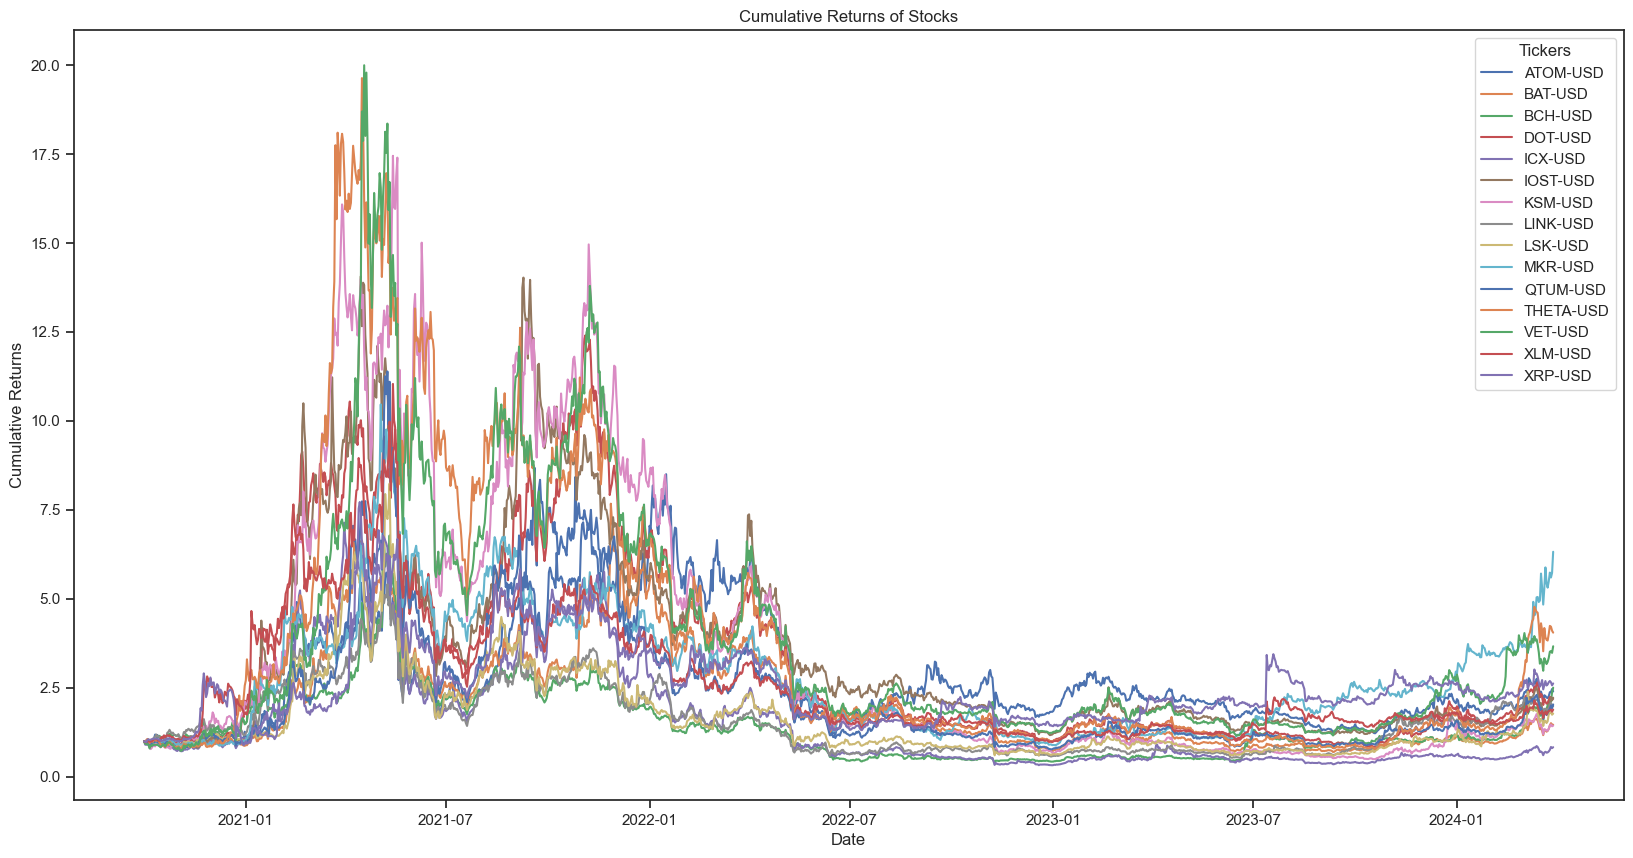

['LTC-USD', 'TRX-USD', 'XMR-USD']


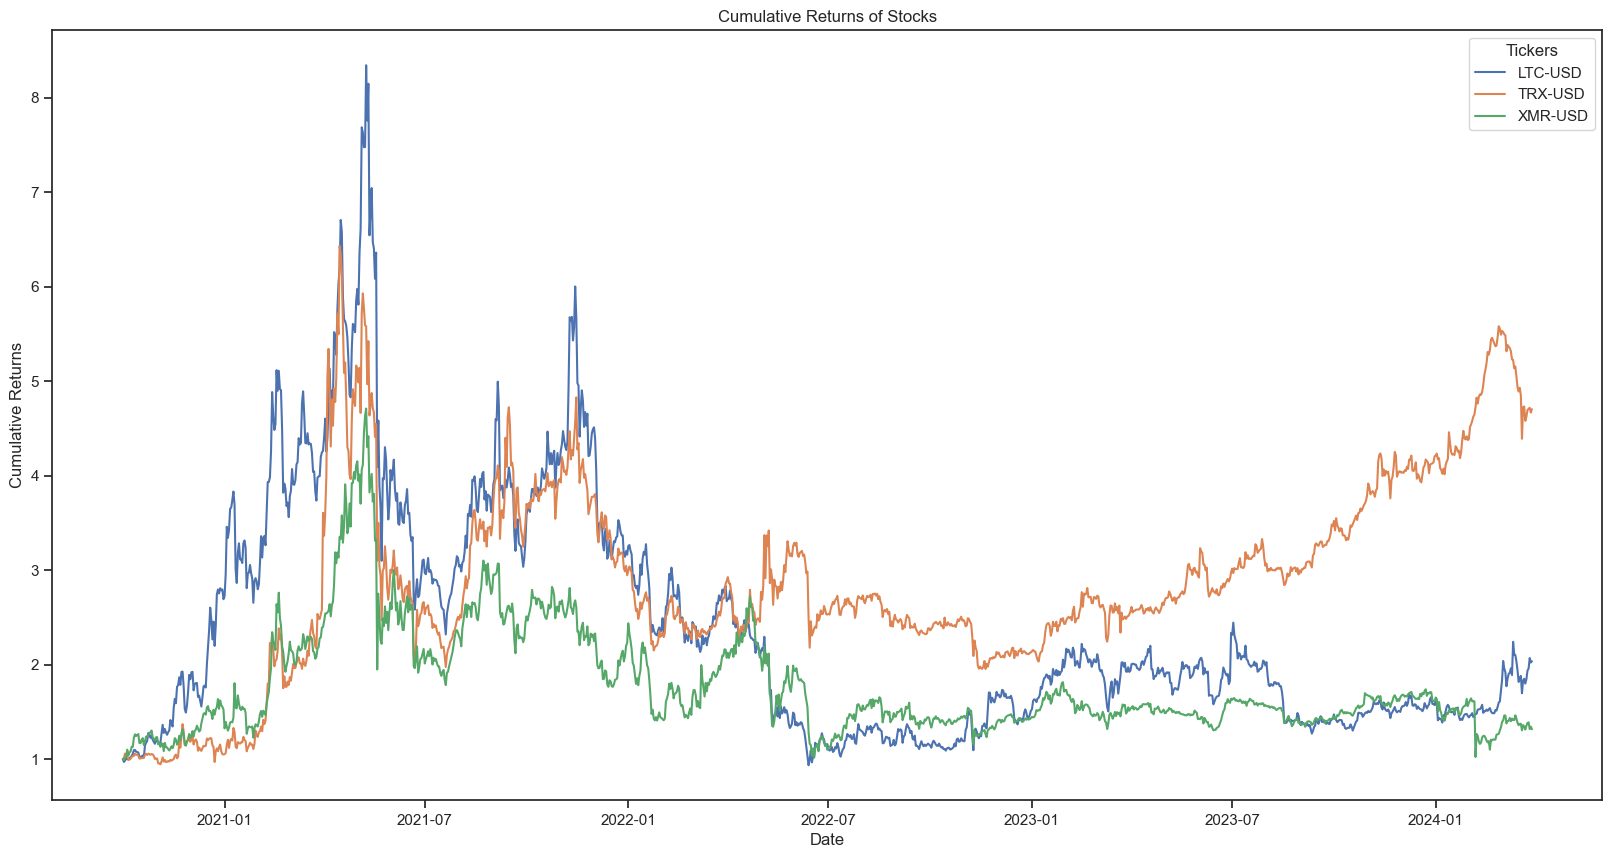

['ALGO-USD', 'BSV-USD', 'CRO-USD', 'DGB-USD', 'EOS-USD', 'OMG-USD', 'ONE-USD', 'ONT-USD', 'SXP-USD', 'XTZ-USD', 'ZEC-USD']


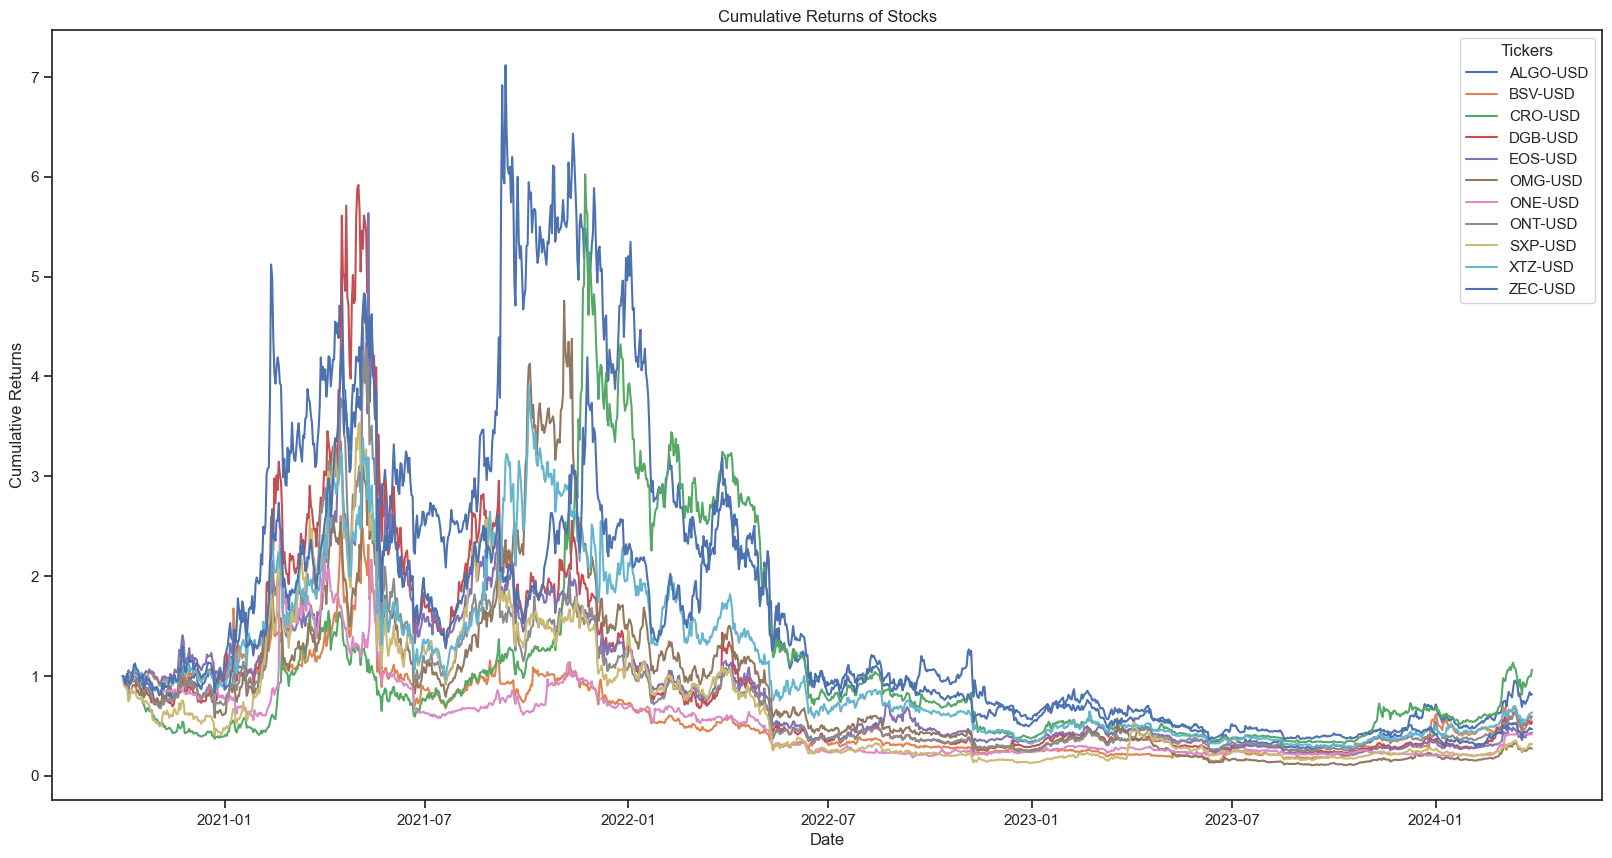

['ANKR-USD', 'ENJ-USD', 'NMR-USD', 'SC-USD', 'SNT-USD', 'SNX-USD', 'WAVES-USD', 'WAXP-USD', 'WIN-USD', 'ZIL-USD', 'ZRX-USD']


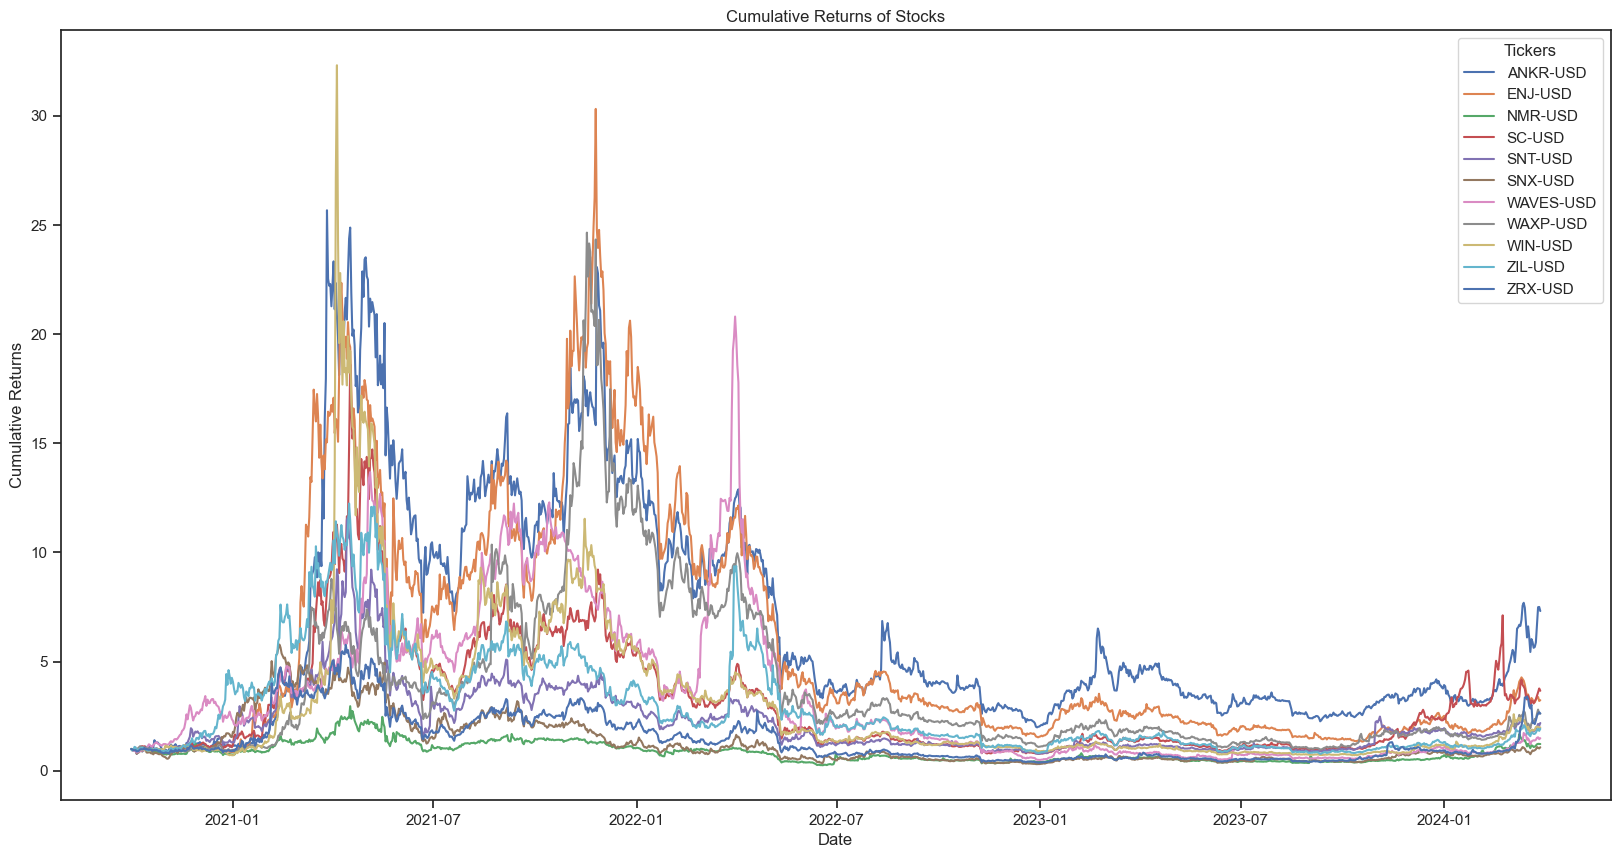

In [44]:
for i in range(0,9):    
    # Retrieve the first row (the starting point)
    print(list(cluster_label[cluster_label['Cluster']==i].Company))
    first_row = data[list(cluster_label[cluster_label['Cluster']==i].Company)].iloc[0]
    
    # Calculate the cumulative returns
    # We divide each day's prices by the first day's prices
    cumulative_returns = data[list(cluster_label[cluster_label['Cluster']==i].Company)] / first_row

    # Plotting the evolution
    # Setting the seaborn style
    sns.set(style="ticks")
    # Plotting the evolution using seaborn's lineplot
    plt.figure(figsize=(20, 10))
    for column in cumulative_returns.columns:
        sns.lineplot(data=cumulative_returns[column], label=column)

    plt.title("Cumulative Returns of Stocks")
    plt.xlabel("Date")
    plt.ylabel("Cumulative Returns")
    plt.legend(title="Tickers")
    plt.savefig(f"cluster{i}.png")
    plt.show()
    



# Gradient Descent Optimization

#### Objective function

The objective function is defined by :
\begin{equation}
f(W) = (R_i - R_xW)^T(R_i - R_xW) - k(W^TW)
\end{equation}
where $R_i$ and $R_x$ are known matrices, $W$ is the variable matrix, and $k$ is a scalar and $k(W^TW)$ is the regularized term

#### Gradient of the function

The gradient of $f(W)$ with respect to $W$ is calculated as follows:

\begin{align}
\nabla f(W) &= -2R_x^T(R_i - R_xW) - 2kW
\end{align}

#### Gradient descent algorithm

The algorithm for minimizing $f(W)$ is shown below:

**Algorithm: Gradient descent to minimize $f(W)$**

1. **Set** $W$ to an arbitrary value.
2. Choose a learning rate $\alpha$ and a convergence threshold $\epsilon$.
3. **Repeat** :
   - Calculate the gradient $\nabla f(W)$.
   - Update $W \leftarrow W - \alpha \nabla f(W)$.
4. **Until** the norm of $\nabla f(W)$ is less than $\epsilon$.


In [45]:
np.random.seed(101) 
class GradientDescentOptimizer:
    def __init__(self, R_i, R_x, alpha=0.01, epsilon=1e-6, max_iter=10000):
        self.R_i = R_i  # Return vector for asset/portfolio i (n, 1)
        self.R_x = R_x  # Matrix of explanatory variables/factors (n, k)
        self.alpha = alpha  # Learning rate
        self.epsilon = epsilon  # Convergence threshold
        self.max_iter = max_iter  # Maximum number of iterations

    def calculate_gradient(self, W, k):
        # Calculate the gradient of the cost function
        predictions = np.dot(self.R_x, W)
        error = self.R_i - predictions
        gradient = -2 * np.dot(self.R_x.T, error) + 2 * k * W
        return gradient

    def cost_function(self, W, k):
        # Calculate the cost function including the regularization term
        predictions = np.dot(self.R_x, W)
        error = self.R_i - predictions
        cost = np.dot(error.T, error) + k * np.dot(W.T, W)
        return cost.item()

    def optimize_W_for_k(self, k):
        W = np.random.randn(self.R_x.shape[1], 1)  # Initialize W as a vector (k, 1)
        for _ in range(self.max_iter):
            gradient = self.calculate_gradient(W, k)
            W -= self.alpha * gradient
            if np.linalg.norm(gradient) < self.epsilon:
                break
        return W, self.cost_function(W, k)

    def find_best_k(self, k_values):
        min_cost = np.inf
        best_k = None
        best_W = None
        for k in k_values:
            W, cost = self.optimize_W_for_k(k)
            if cost < min_cost:
                min_cost = cost
                best_k = k
                best_W = W
        return best_k, best_W, min_cost

In [46]:
data

Ticker       ADA-USD  ALGO-USD  ANKR-USD     AR-USD   ATOM-USD   AVAX-USD  \
Date                                                                        
2020-10-01  0.097865  0.334291  0.007569   4.246261   5.129178   4.151090   
2020-10-02  0.092921  0.317115  0.007291   4.425807   4.908415   3.927156   
2020-10-03  0.093413  0.313876  0.007327   4.197838   5.018135   4.021660   
2020-10-04  0.096348  0.313273  0.007289   4.147193   5.306819   3.961110   
2020-10-05  0.097544  0.317872  0.007057   4.065870   5.382198   3.978020   
...              ...       ...       ...        ...        ...        ...   
2024-03-24  0.646157  0.256103  0.044482  37.523773  11.611394  55.664196   
2024-03-25  0.656949  0.268201  0.050550  42.517330  12.185326  57.823334   
2024-03-26  0.665034  0.280121  0.056710  41.186485  12.216667  55.818089   
2024-03-27  0.648483  0.270657  0.056797  42.698448  12.639974  54.114628   
2024-03-28  0.650794  0.272634  0.055381  41.494015  12.298833  54.621883   

Ticker      BAND-USD   BAT-USD   BCD-USD     BCH-USD  ...   WIN-USD   XLM-USD  \
Date                                                  ...                       
2020-10-01  6.413685  0.230202  0.531012  227.419205  ...  0.000083  0.073172   
2020-10-02  6.074012  0.223896  0.513087  220.021805  ...  0.000080  0.071097   
2020-10-03  5.938618  0.221100  0.557907  218.863785  ...  0.000083  0.071157   
2020-10-04  5.966622  0.221511  0.536718  221.392395  ...  0.000083  0.072955   
2020-10-05  5.891822  0.221232  0.536470  222.050323  ...  0.000083  0.073419   
...              ...       ...       ...         ...  ...       ...       ...   
2024-03-24  2.098577  0.309904  0.139252  484.753632  ...  0.000166  0.135005   
2024-03-25  2.188411  0.332190  0.137378  488.045959  ...  0.000167  0.136683   
2024-03-26  2.258034  0.346510  0.148276  480.107361  ...  0.000168  0.138183   
2024-03-27  2.213657  0.337055  0.138659  539.793335  ...  0.000160  0.133770   
2024-03-28  2.225347  0.336400  0.143344  569.156982  ...  0.000165  0.138054   

Ticker         XMR-USD   XRP-USD   XTZ-USD   XVG-USD    ZEC-USD   ZIL-USD  \
Date                                                                        
2020-10-01  102.658134  0.238249  2.225466  0.004074  65.985596  0.019409   
2020-10-02  101.715714  0.234117  2.091950  0.003988  65.079826  0.018089   
2020-10-03  103.658508  0.232938  2.115696  0.004012  60.686058  0.018595   
2020-10-04  105.563141  0.247685  2.112973  0.004020  63.067760  0.021277   
2020-10-05  112.903252  0.250816  2.214748  0.004258  67.464317  0.020796   
...                ...       ...       ...       ...        ...       ...   
2024-03-24  141.886597  0.632950  1.294693  0.006006  29.774647  0.033921   
2024-03-25  142.586914  0.641034  1.350189  0.006248  30.313675  0.035947   
2024-03-26  135.327347  0.632253  1.378362  0.006554  31.625679  0.037294   
2024-03-27  137.917847  0.611964  1.390208  0.006333  30.989096  0.035477   
2024-03-28  135.064209  0.624554  1.413130  0.006328  30.781263  0.037310   

Ticker       ZRX-USD  Index Price  
Date                               
2020-10-01  0.398848     5.367509  
2020-10-02  0.389794     5.228817  
2020-10-03  0.376901     5.334264  
2020-10-04  0.376209     5.430155  
2020-10-05  0.377584     5.440708  
...              ...          ...  
2024-03-24  0.920500    92.136125  
2024-03-25  1.004046    95.254568  
2024-03-26  1.044468    94.478492  
2024-03-27  1.068885    93.081263  
2024-03-28  1.047173    94.455831  

[1275 rows x 68 columns]

## Tracking Problem resolution 

#### Tracking with Affinity Propagation Selection 

In [47]:
# Initialize an empty list to hold all affinity selections
affinity_selections = []

# Iterate through the cluster numbers you're interested in combining with cluster 0
for cluster_num in range(1, 10): 
    # Create a selection list by starting with companies from cluster 0
    selection = list(cluster_label[cluster_label['Cluster'] == 0].Company)
    
    # Extend the selection by adding companies from the current cluster
    selection.extend(list(cluster_label[cluster_label['Cluster'] == cluster_num].Company))
    
    # Remove the specific company '^SOX' from the selection
    if 'Index Price' in selection:
        selection.remove('Index Price')
    
    # Add the final selection to the list of all selections
    affinity_selections.append(selection)

In [48]:
best_W_AF = [None] * 9  # Pré-allouer de l'espace pour les résultats

for i in range(9):
    # DataFrame de rendement
    df = data[affinity_selections[i]].pct_change().iloc[1:]
    
    # Séparation des données en entraînement et test
    split_point = int(len(df) * 0.7)
    train_data = df[:split_point]
    test_data = df[split_point:]
    
    # Optimisation
    R_i = np.array(data[['Index Price']].pct_change().iloc[1:][:split_point])  # Rendements pour l'actif/le portefeuille i (n, 1)
    R_x = np.array(train_data)  # Variables explicatives/facteurs (n, k)
    
    # Assurez-vous que la classe/fonction GradientDescentOptimizer est définie correctement
    optimizer = GradientDescentOptimizer(R_i, R_x)
    k_values = np.linspace(0.01, 1, 100)  # Valeurs de k à tester
    
    # Stockez le meilleur résultat dans la liste pré-allouée
    best_W_AF[i] = optimizer.find_best_k(k_values)[1]

# Results

#### Evolution of returns 

#### Evolution of cumulative return Train Period 

In [50]:
data

Ticker       ADA-USD  ALGO-USD  ANKR-USD     AR-USD   ATOM-USD   AVAX-USD  \
Date                                                                        
2020-10-01  0.097865  0.334291  0.007569   4.246261   5.129178   4.151090   
2020-10-02  0.092921  0.317115  0.007291   4.425807   4.908415   3.927156   
2020-10-03  0.093413  0.313876  0.007327   4.197838   5.018135   4.021660   
2020-10-04  0.096348  0.313273  0.007289   4.147193   5.306819   3.961110   
2020-10-05  0.097544  0.317872  0.007057   4.065870   5.382198   3.978020   
...              ...       ...       ...        ...        ...        ...   
2024-03-24  0.646157  0.256103  0.044482  37.523773  11.611394  55.664196   
2024-03-25  0.656949  0.268201  0.050550  42.517330  12.185326  57.823334   
2024-03-26  0.665034  0.280121  0.056710  41.186485  12.216667  55.818089   
2024-03-27  0.648483  0.270657  0.056797  42.698448  12.639974  54.114628   
2024-03-28  0.650794  0.272634  0.055381  41.494015  12.298833  54.621883   

Ticker      BAND-USD   BAT-USD   BCD-USD     BCH-USD  ...   WIN-USD   XLM-USD  \
Date                                                  ...                       
2020-10-01  6.413685  0.230202  0.531012  227.419205  ...  0.000083  0.073172   
2020-10-02  6.074012  0.223896  0.513087  220.021805  ...  0.000080  0.071097   
2020-10-03  5.938618  0.221100  0.557907  218.863785  ...  0.000083  0.071157   
2020-10-04  5.966622  0.221511  0.536718  221.392395  ...  0.000083  0.072955   
2020-10-05  5.891822  0.221232  0.536470  222.050323  ...  0.000083  0.073419   
...              ...       ...       ...         ...  ...       ...       ...   
2024-03-24  2.098577  0.309904  0.139252  484.753632  ...  0.000166  0.135005   
2024-03-25  2.188411  0.332190  0.137378  488.045959  ...  0.000167  0.136683   
2024-03-26  2.258034  0.346510  0.148276  480.107361  ...  0.000168  0.138183   
2024-03-27  2.213657  0.337055  0.138659  539.793335  ...  0.000160  0.133770   
2024-03-28  2.225347  0.336400  0.143344  569.156982  ...  0.000165  0.138054   

Ticker         XMR-USD   XRP-USD   XTZ-USD   XVG-USD    ZEC-USD   ZIL-USD  \
Date                                                                        
2020-10-01  102.658134  0.238249  2.225466  0.004074  65.985596  0.019409   
2020-10-02  101.715714  0.234117  2.091950  0.003988  65.079826  0.018089   
2020-10-03  103.658508  0.232938  2.115696  0.004012  60.686058  0.018595   
2020-10-04  105.563141  0.247685  2.112973  0.004020  63.067760  0.021277   
2020-10-05  112.903252  0.250816  2.214748  0.004258  67.464317  0.020796   
...                ...       ...       ...       ...        ...       ...   
2024-03-24  141.886597  0.632950  1.294693  0.006006  29.774647  0.033921   
2024-03-25  142.586914  0.641034  1.350189  0.006248  30.313675  0.035947   
2024-03-26  135.327347  0.632253  1.378362  0.006554  31.625679  0.037294   
2024-03-27  137.917847  0.611964  1.390208  0.006333  30.989096  0.035477   
2024-03-28  135.064209  0.624554  1.413130  0.006328  30.781263  0.037310   

Ticker       ZRX-USD  Index Price  
Date                               
2020-10-01  0.398848     5.367509  
2020-10-02  0.389794     5.228817  
2020-10-03  0.376901     5.334264  
2020-10-04  0.376209     5.430155  
2020-10-05  0.377584     5.440708  
...              ...          ...  
2024-03-24  0.920500    92.136125  
2024-03-25  1.004046    95.254568  
2024-03-26  1.044468    94.478492  
2024-03-27  1.068885    93.081263  
2024-03-28  1.047173    94.455831  

[1275 rows x 68 columns]

In [54]:
# Calculate the Benchmark
index_return = data[:split_point]['Index Price'] / data[:split_point]['Index Price'].iloc[0]

# Calculate daily returns for assets in the portfolio
daily_returns = [data[selection].pct_change().iloc[1:][:split_point] for selection in affinity_selections[:9]]

# Retrieve weights for assets in the portfolio from the list or dict
weights = [best_W_AF[i][:,0] for i in range(9)]  # Directly access from list or dict

# Calculate weighted returns for the portfolio
tracking_portfolio_returns = [(daily_returns[i] * weights[i]).sum(axis=1) for i in range(9)]

# Calculate cumulative returns for the portfolio
cumulative_returns = [(1 + tracking_portfolio_returns[i]).cumprod() for i in range(9)]

# Create a DataFrame to hold the results
results_df = pd.DataFrame({
    'Index': index_return,
    **{f'Tracking Portfolio AF{i+1}': cumulative_returns[i] for i in range(9)}
}, index=index_return.index)

results_df = results_df.dropna()

In [55]:
results_df

Index  Tracking Portfolio AF1  Tracking Portfolio AF2  \
Date                                                                   
2020-10-02  0.974161                0.952399                0.979174   
2020-10-03  0.993806                0.959669                1.000275   
2020-10-04  1.011671                0.955833                1.016136   
2020-10-05  1.013637                0.952280                1.012144   
2020-10-06  0.949304                0.878695                0.955837   
...              ...                     ...                     ...   
2023-03-06  6.965943                7.954577               12.437548   
2023-03-07  6.976370                7.787954               12.401511   
2023-03-08  6.853745                7.319194               12.065580   
2023-03-09  6.605334                6.983172               11.620806   
2023-03-10  6.641659                7.025799               11.719981   

            Tracking Portfolio AF3  Tracking Portfolio AF4  \
Date                                                         
2020-10-02                0.957977                0.959230   
2020-10-03                0.959648                0.962441   
2020-10-04                0.953953                0.958061   
2020-10-05                0.956325                0.962265   
2020-10-06                0.877916                0.888288   
...                            ...                     ...   
2023-03-06               14.494874                9.489098   
2023-03-07               14.297440                9.321903   
2023-03-08               13.500965                8.803435   
2023-03-09               12.957542                8.436101   
2023-03-10               13.220399                8.535510   

            Tracking Portfolio AF5  Tracking Portfolio AF6  \
Date                                                         
2020-10-02                0.952711                0.960920   
2020-10-03                0.948979                0.970980   
2020-10-04                0.954139                0.970573   
2020-10-05                0.963785                0.985084   
2020-10-06                0.886109                0.910643   
...                            ...                     ...   
2023-03-06                5.606152                9.193412   
2023-03-07                5.554974                9.069678   
2023-03-08                5.269459                8.595699   
2023-03-09                5.014311                8.164412   
2023-03-10                5.109049                8.148448   

            Tracking Portfolio AF7  Tracking Portfolio AF8  \
Date                                                         
2020-10-02                0.953527                0.954612   
2020-10-03                0.950118                0.954733   
2020-10-04                0.949968                0.951637   
2020-10-05                0.963069                0.960189   
2020-10-06                0.888307                0.882666   
...                            ...                     ...   
2023-03-06                4.839995                9.534438   
2023-03-07                4.772167                9.379302   
2023-03-08                4.503933                8.865927   
2023-03-09                4.295048                8.450742   
2023-03-10                4.341116                8.603411   

            Tracking Portfolio AF9  
Date                                
2020-10-02                0.957860  
2020-10-03                0.959464  
2020-10-04                0.953741  
2020-10-05                0.955930  
2020-10-06                0.877337  
...                            ...  
2023-03-06               14.240802  
2023-03-07               14.045637  
2023-03-08               13.262658  
2023-03-09               12.729785  
2023-03-10               12.987934  

[890 rows x 10 columns]

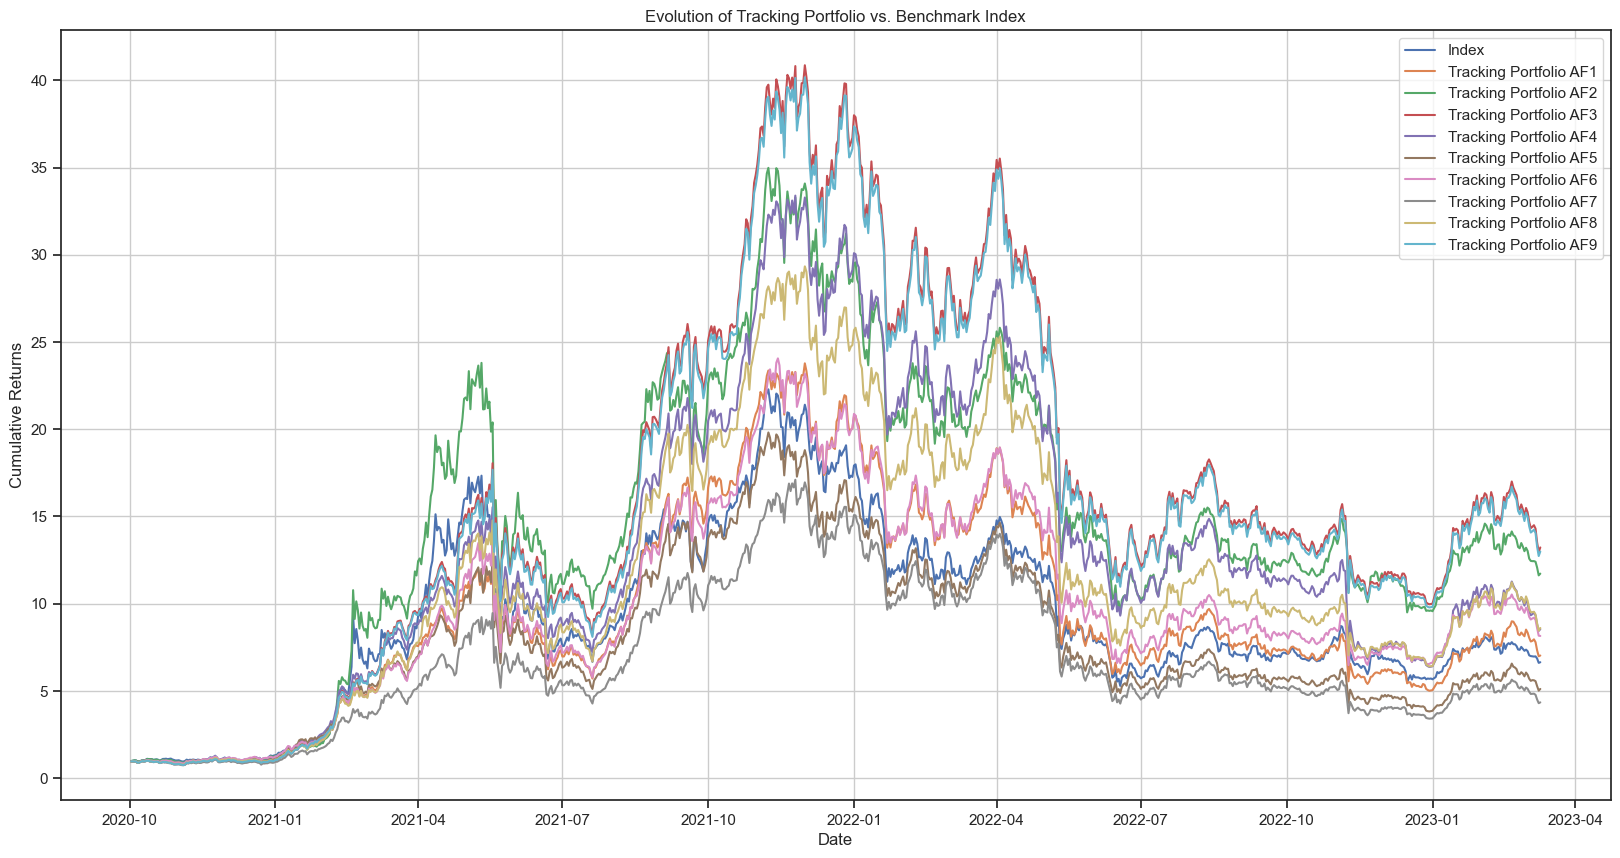

In [56]:
# Set the size of the plot
plt.figure(figsize=(20, 10))

# Iterate over the columns in results_df and plot each one
for column in results_df.columns:
    plt.plot(results_df.index, results_df[column], label=column)

# Set the title, labels for x and y axes, and enable the grid
plt.title('Evolution of Tracking Portfolio vs. Benchmark Index')
plt.xlabel('Date')
plt.ylabel('Cumulative Returns')
plt.grid(True)

# Add a legend to the plot
plt.legend()

# Save the figure to a file and show it
plt.savefig("result_train.png")
plt.show()

#### Evolution of cumulative return Test Period 

In [57]:
# Calculate the Benchmark
index_return = data[split_point:]['Index Price'] / data[split_point:]['Index Price'].iloc[0]

# Calculate daily returns for assets in the portfolio
daily_returns = [data[selection].pct_change().iloc[1:][split_point:] for selection in affinity_selections[:9]]

# Retrieve weights for assets in the portfolio from the list or dict
weights = [best_W_AF[i][:,0] for i in range(9)]  # Directly access from list or dict

# Calculate weighted returns for the portfolio
tracking_portfolio_returns = [(daily_returns[i] * weights[i]).sum(axis=1) for i in range(9)]

# Calculate cumulative returns for the portfolio
cumulative_returns = [(1 + tracking_portfolio_returns[i]).cumprod() for i in range(9)]

# Create a DataFrame to hold the results
results_df = pd.DataFrame({
    'Index': index_return,
    **{f'Tracking Portfolio AF{i+1}': cumulative_returns[i] for i in range(9)}
}, index=index_return.index)

results_df = results_df.dropna()

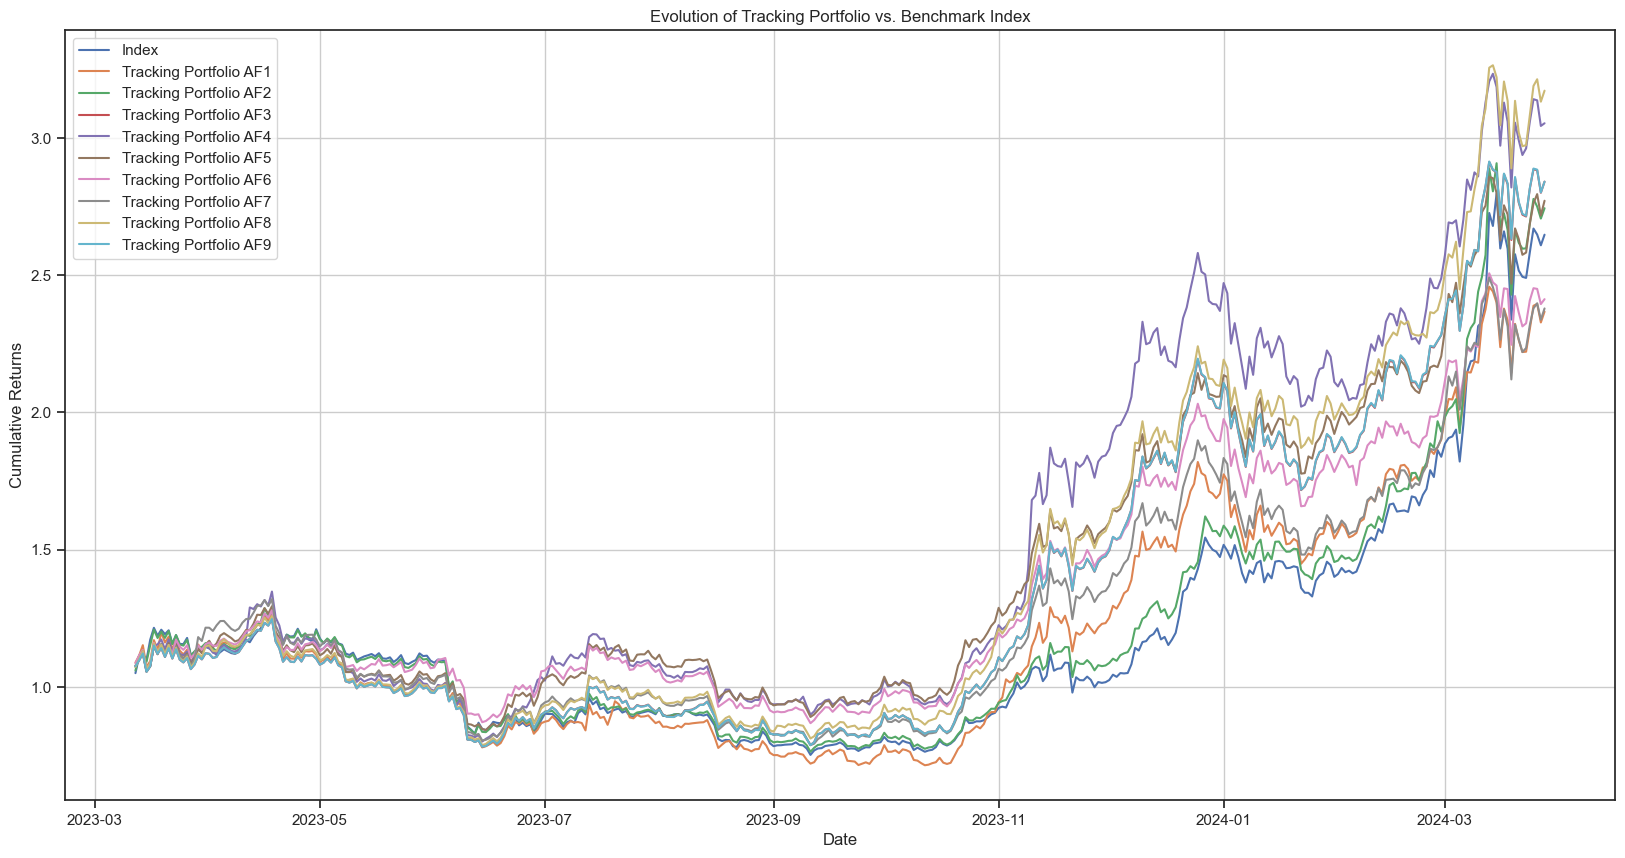

In [60]:
# Set the size of the plot
plt.figure(figsize=(20, 10))

# Iterate over the columns in results_df and plot each one
for column in results_df.columns:
    plt.plot(results_df.index, results_df[column], label=column)

# Set the title, labels for x and y axes, and enable the grid
plt.title('Evolution of Tracking Portfolio vs. Benchmark Index')
plt.xlabel('Date')
plt.ylabel('Cumulative Returns')
plt.grid(True)

# Add a legend to the plot
plt.legend()

# Save the figure to a file and show it
plt.savefig("result_train.png")
plt.show()

In [61]:
def calculate_ate(index_returns, portfolio_returns):
    """
    Calculate the Average Tracking Error (ATE) between the index returns and the portfolio returns.
    
    Parameters:
    index_returns (np.array): Array of returns from the index.
    portfolio_returns (np.array): Array of returns from the tracking portfolio.
    
    Returns:
    float: The calculated ATE.
    """
    T = len(index_returns)
    if T != len(portfolio_returns):
        raise ValueError("The length of index returns and portfolio returns must be the same.")
    
    ate = np.sqrt(np.sum((index_returns - portfolio_returns)**2) / T)
    return ate

In [62]:
ate_results = {}
for column in results_df.columns[1:]:  # Exclude the first column which is 'SOX'
    ate_results[column] = calculate_ate(results_df['Index'], results_df[column])

# Convert the results dictionary to a DataFrame
ate_results_df = pd.DataFrame(list(ate_results.items()), columns=['Portfolio', 'ATE']).sort_values(by='ATE')
ate_results_df

Portfolio       ATE
1  Tracking Portfolio AF2  0.049084
0  Tracking Portfolio AF1  0.131959
6  Tracking Portfolio AF7  0.169563
5  Tracking Portfolio AF6  0.251536
2  Tracking Portfolio AF3  0.289058
8  Tracking Portfolio AF9  0.290095
4  Tracking Portfolio AF5  0.331519
7  Tracking Portfolio AF8  0.370051
3  Tracking Portfolio AF4  0.481742

In [63]:
results = results_df.mean() * 252
results = pd.DataFrame(results)
results.columns = ['Returns']
results['Volatility'] = results_df.std() * np.sqrt(252)
results

Returns  Volatility
Index                   296.264908    6.759332
Tracking Portfolio AF1  301.952795    6.900624
Tracking Portfolio AF2  304.221513    7.222045
Tracking Portfolio AF3  338.941795    9.050566
Tracking Portfolio AF4  380.605599   10.411393
Tracking Portfolio AF5  357.046398    8.328761
Tracking Portfolio AF6  339.445586    6.939533
Tracking Portfolio AF7  317.440309    6.668548
Tracking Portfolio AF8  356.279148   10.081556
Tracking Portfolio AF9  339.074954    9.064941

In [64]:
combined_results_df = ate_results_df.set_index('Portfolio').join(results)
combined_results_df.reset_index(inplace=True)
combined_results_df.to_csv('result.csv')

In [65]:
combined_results_df

Portfolio       ATE     Returns  Volatility
0  Tracking Portfolio AF2  0.049084  304.221513    7.222045
1  Tracking Portfolio AF1  0.131959  301.952795    6.900624
2  Tracking Portfolio AF7  0.169563  317.440309    6.668548
3  Tracking Portfolio AF6  0.251536  339.445586    6.939533
4  Tracking Portfolio AF3  0.289058  338.941795    9.050566
5  Tracking Portfolio AF9  0.290095  339.074954    9.064941
6  Tracking Portfolio AF5  0.331519  357.046398    8.328761
7  Tracking Portfolio AF8  0.370051  356.279148   10.081556
8  Tracking Portfolio AF4  0.481742  380.605599   10.411393